In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import mean_squared_error

# Для визуализации графиков CatBoost надо установить ipywidgets
#!pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
import ipywidgets

pd.options.mode.chained_assignment = None

In [2]:
PATH = "datasets/train_dataset_VK/"
submission_filename = "submission.csv"

## Загрузка данных

In [17]:
# Обучающая выборка разбита на файлы
datset_filenames = ["rich_test_1M_1.csv", "rich_test_1M_2.csv", "rich_test_1M_3.csv", "rich_test_1M_4.csv", "rich_test_1M_5.csv", "rich_test_1M_6.csv", "rich_test_1M_7.csv", "rich_test_1M_8.csv", "rich_test_1M_9.csv", "rich_test_1M_10.csv", "rich_test_1M_11.csv", "rich_test_1M_12.csv"]
datset_filenames = ["rich_test_1M_1.csv", "rich_test_1M_2.csv"]
datset_filenames = ["rich_v2_test_1M_40.csv"]
datset_filenames = ["rich_v3_test_1M_40.csv"]
print(f"Использованы данные {len(datset_filenames)} из 40")
datset_df = pd.DataFrame()
for filename in datset_filenames:
    partfile_df = pd.read_csv(PATH + filename)
    datset_df = pd.concat([datset_df, partfile_df], axis=0)
datset_df.shape

Использованы данные 1 из 40


(246938, 29)

In [18]:
datset_df

,ego_id,u,v,t,x1,x2,x3,is_t_exist,age_x,sex_1_x,...,school_freq_y,ego_age,friendship,friendship_x2,friendship_x3,friendship_x3_cnt,time_by_ages,time_by_friendship,time_by_friendship_x2,time_by_friendship_x3
0,1692217114973,96,102,58.6,1.290927,0.000000,1.0,1,20,1,...,125,26,0.930955,0.365994,0.279070,36.0,2.930000,62.946082,160.111863,209.983333
1,1692217114973,63,102,58.7,1.097865,0.000000,0.0,1,27,1,...,125,26,0.759152,0.214553,0.108280,17.0,2.174074,77.323157,273.592290,542.111765
2,1692217114973,39,102,57.4,0.006175,0.000000,1.0,1,32,1,...,125,26,0.479587,0.123819,0.095652,11.0,1.793750,119.686212,463.580163,600.090909
3,1692217114973,82,102,58.1,1.814976,0.000000,1.0,1,25,1,...,125,26,0.454166,0.115268,0.105263,12.0,2.324000,127.926653,504.042265,551.950000
4,1692217114973,73,102,58.1,NaN,0.000000,1.0,1,30,0,...,125,26,0.514715,0.123968,0.188679,20.0,1.936667,112.878008,468.670878,307.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246933,1700807049745,110,114,196.3,1.147634,0.693147,0.0,1,23,1,...,120,39,0.326352,0.099021,0.000000,0.0,8.534783,601.498168,1982.407256,inf
246934,1700807049745,109,114,92.2,0.776584,0.000000,0.0,1,25,1,...,120,39,0.665648,0.158395,0.185185,5.0,3.688000,138.511620,582.088929,497.880000
246935,1700807049745,105,114,200.4,0.802819,0.000000,0.0,1,53,0,...,120,39,0.537379,0.081547,0.058824,1.0,3.781132,372.920898,2457.486733,3406.800000
246936,1700807049745,10,124,3.7,0.747339,0.000000,1.0,1,44,1,...,120,39,0.098061,0.000000,0.729730,27.0,0.084091,37.731534,inf,5.070370


In [21]:
datset_df["time_by_friendship"] = datset_df["time_by_friendship"].fillna(0)
datset_df["time_by_friendship_x2"] = datset_df["time_by_friendship_x2"].fillna(0)
datset_df["time_by_friendship_x3"] = datset_df["time_by_friendship_x3"].fillna(0)
datset_df.isna().sum()

ego_id                       0
u                            0
v                            0
t                            0
x1                       49382
x2                           0
x3                           0
is_t_exist                   0
age_x                        0
sex_1_x                      0
sex_2_x                      0
city_freq_x                  0
university_freq_x            0
school_freq_x                0
age_y                        0
sex_1_y                      0
sex_2_y                      0
city_freq_y                  0
university_freq_y            0
school_freq_y                0
ego_age                      0
friendship                   0
friendship_x2                0
friendship_x3                0
friendship_x3_cnt            0
time_by_ages                 0
time_by_friendship           0
time_by_friendship_x2        0
time_by_friendship_x3        0
dtype: int64

In [6]:
# union_df = datset_df
# union_df["eqaul_sex"] = union_df.apply(lambda x: 1 if (x["sex_2_x"] == x["sex_2_y"]) or (x["sex_1_x"] == x["sex_1_y"]) else 0, axis=1)
# union_df["eqaul_sex"]

In [60]:
# union_df[(union_df["age_y"] == -1)|(union_df["age_y"] > 90)] = -1

In [7]:
# union_df = datset_df

# # datset_df["delta_age"] = 
# # union_df["eqaul_sex"] = 0
# # union_df["eqaul_sex"] = union_df["eqaul_sex"].apply(lambda x: 1 if x["sex_2_x"] == x["sex_2_y"] else 0)
# # union_df["eqaul_sex"]

# # union_df["eqaul_sex"] = 0
# union_df["delta_age"] = abs(union_df["age_x"] - union_df["age_y"])
# union_df

In [8]:
# union_df[union_df["eqaul_sex"] == 1]

### Готовим данные для модели

In [22]:
train_df = datset_df[datset_df["x1"].notna()]
test_df = datset_df[datset_df["x1"].isna()]
test_df.shape, train_df.shape

((49382, 29), (197556, 29))

In [23]:
datset_df.columns

Index(['ego_id', 'u', 'v', 't', 'x1', 'x2', 'x3', 'is_t_exist', 'age_x',
       'sex_1_x', 'sex_2_x', 'city_freq_x', 'university_freq_x',
       'school_freq_x', 'age_y', 'sex_1_y', 'sex_2_y', 'city_freq_y',
       'university_freq_y', 'school_freq_y', 'ego_age', 'friendship',
       'friendship_x2', 'friendship_x3', 'friendship_x3_cnt', 'time_by_ages',
       'time_by_friendship', 'time_by_friendship_x2', 'time_by_friendship_x3'],
      dtype='object')

In [24]:
# train_df.columns
# data_columns = ['u', 'v', 't', 'x2', 'x3', 'is_t_exist', 'friendship', 'age_x', 'sex_1_x', 'sex_2_x', 'city_freq_x', 'university_freq_x', 'school_freq_x', 'age_y', 'sex_1_y', 'sex_2_y', 'city_freq_y', 'university_freq_y', 'school_freq_y']
# data_columns = ['u', 'v', 't', 'x2', 'x3', 'is_t_exist', 'age_x',
#        'sex_1_x', 'sex_2_x', 'city_freq_x', 'university_freq_x',
#        'school_freq_x', 'age_y', 'sex_1_y', 'sex_2_y', 'city_freq_y',
#        'university_freq_y', 'school_freq_y', 'ego_age', 'friendship',
#        'friendship_x2', 'friendship_x3', 'friendship_x3_cnt', 'eqaul_sex',
#        'eqaul_school', 'eqaul_university', 'eqaul_city', 'delta_age']

data_columns = ['u', 'v', 't', 'x2', 'x3', 'is_t_exist', 'age_x',
       'sex_1_x', 'sex_2_x', 'city_freq_x', 'university_freq_x',
       'school_freq_x', 'age_y', 'sex_1_y', 'sex_2_y', 'city_freq_y',
       'university_freq_y', 'school_freq_y', 'ego_age', 'friendship',
       'friendship_x2', 'friendship_x3', 'friendship_x3_cnt', 'time_by_ages',
       'time_by_friendship', 'time_by_friendship_x2', 'time_by_friendship_x3']

target_column = "x1"

x_train_df = train_df[data_columns]
y_train_df = train_df[target_column]
y_test = test_df[data_columns]

x_train_df.shape, y_train_df.shape

((197556, 27), (197556,))

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=53, shuffle=True)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((158044, 27), (39512, 27), (158044,), (39512,))

### Обучаем модель

In [26]:
from catboost import CatBoostRegressor, Pool
from catboost import cv

In [14]:
# # Производим поиск гиперпараметров
# cat = CatBoostRegressor()
# cv_dataset = Pool(data=x_train,
#                   label=y_train)
# grid = {'iterations': [600],
#         'learning_rate': [0.2,0.3,0.4],
#         'depth':  [5,6,7],
#         'l2_leaf_reg': [2,3,4],
#         "random_strength": [2],
#        }
# cat.grid_search(grid, cv_dataset, verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5307924	test: 1.5233931	best: 1.5233931 (0)	total: 190ms	remaining: 1m 53s
1:	learn: 1.3608868	test: 1.3535682	best: 1.3535682 (1)	total: 210ms	remaining: 1m 2s
2:	learn: 1.2326464	test: 1.2261328	best: 1.2261328 (2)	total: 229ms	remaining: 45.6s
3:	learn: 1.1405756	test: 1.1337018	best: 1.1337018 (3)	total: 252ms	remaining: 37.6s
4:	learn: 1.0606036	test: 1.0541031	best: 1.0541031 (4)	total: 283ms	remaining: 33.7s
5:	learn: 1.0121050	test: 1.0056923	best: 1.0056923 (5)	total: 304ms	remaining: 30.1s
6:	learn: 0.9659961	test: 0.9603557	best: 0.9603557 (6)	total: 333ms	remaining: 28.2s
7:	learn: 0.9370135	test: 0.9315322	best: 0.9315322 (7)	total: 353ms	remaining: 26.1s
8:	learn: 0.9126820	test: 0.9077092	best: 0.9077092 (8)	total: 381ms	remaining: 25s
9:	learn: 0.8883747	test: 0.8848708	best: 0.8848708 (9)	total: 402ms	remaining: 23.7s
10:	learn: 0.8750906	test: 0.8713942	best: 0.8713942 (10)	total: 430ms	remaining: 23s
11:	learn: 0.8646230	test: 0.8623071	best: 0.8623071 (1

95:	learn: 0.7556419	test: 0.7704728	best: 0.7704728 (95)	total: 2.45s	remaining: 12.9s
96:	learn: 0.7553289	test: 0.7702781	best: 0.7702781 (96)	total: 2.48s	remaining: 12.8s
97:	learn: 0.7550289	test: 0.7700241	best: 0.7700241 (97)	total: 2.5s	remaining: 12.8s
98:	learn: 0.7548177	test: 0.7699164	best: 0.7699164 (98)	total: 2.52s	remaining: 12.7s
99:	learn: 0.7544930	test: 0.7696968	best: 0.7696968 (99)	total: 2.54s	remaining: 12.7s
100:	learn: 0.7543027	test: 0.7696887	best: 0.7696887 (100)	total: 2.56s	remaining: 12.6s
101:	learn: 0.7539643	test: 0.7696741	best: 0.7696741 (101)	total: 2.58s	remaining: 12.6s
102:	learn: 0.7536593	test: 0.7695038	best: 0.7695038 (102)	total: 2.6s	remaining: 12.6s
103:	learn: 0.7532575	test: 0.7693219	best: 0.7693219 (103)	total: 2.62s	remaining: 12.5s
104:	learn: 0.7530105	test: 0.7690699	best: 0.7690699 (104)	total: 2.65s	remaining: 12.5s
105:	learn: 0.7526664	test: 0.7688038	best: 0.7688038 (105)	total: 2.67s	remaining: 12.4s
106:	learn: 0.7523460	

194:	learn: 0.7343871	test: 0.7615054	best: 0.7615054 (194)	total: 4.68s	remaining: 9.72s
195:	learn: 0.7342095	test: 0.7614660	best: 0.7614660 (195)	total: 4.7s	remaining: 9.69s
196:	learn: 0.7341254	test: 0.7614288	best: 0.7614288 (196)	total: 4.72s	remaining: 9.67s
197:	learn: 0.7339886	test: 0.7613586	best: 0.7613586 (197)	total: 4.74s	remaining: 9.63s
198:	learn: 0.7338830	test: 0.7613575	best: 0.7613575 (198)	total: 4.76s	remaining: 9.6s
199:	learn: 0.7337404	test: 0.7614269	best: 0.7613575 (198)	total: 4.79s	remaining: 9.57s
200:	learn: 0.7335776	test: 0.7614533	best: 0.7613575 (198)	total: 4.81s	remaining: 9.54s
201:	learn: 0.7334506	test: 0.7613861	best: 0.7613575 (198)	total: 4.83s	remaining: 9.52s
202:	learn: 0.7332765	test: 0.7613516	best: 0.7613516 (202)	total: 4.85s	remaining: 9.49s
203:	learn: 0.7331124	test: 0.7612053	best: 0.7612053 (203)	total: 4.87s	remaining: 9.46s
204:	learn: 0.7330082	test: 0.7611490	best: 0.7611490 (204)	total: 4.9s	remaining: 9.44s
205:	learn: 0

286:	learn: 0.7220405	test: 0.7577752	best: 0.7577580 (282)	total: 6.67s	remaining: 7.27s
287:	learn: 0.7219461	test: 0.7578148	best: 0.7577580 (282)	total: 6.68s	remaining: 7.24s
288:	learn: 0.7217881	test: 0.7577302	best: 0.7577302 (288)	total: 6.71s	remaining: 7.21s
289:	learn: 0.7216545	test: 0.7577284	best: 0.7577284 (289)	total: 6.72s	remaining: 7.19s
290:	learn: 0.7215211	test: 0.7577996	best: 0.7577284 (289)	total: 6.74s	remaining: 7.16s
291:	learn: 0.7214228	test: 0.7577163	best: 0.7577163 (291)	total: 6.76s	remaining: 7.14s
292:	learn: 0.7212865	test: 0.7576363	best: 0.7576363 (292)	total: 6.79s	remaining: 7.11s
293:	learn: 0.7211871	test: 0.7575812	best: 0.7575812 (293)	total: 6.81s	remaining: 7.09s
294:	learn: 0.7211256	test: 0.7575655	best: 0.7575655 (294)	total: 6.83s	remaining: 7.06s
295:	learn: 0.7209842	test: 0.7574919	best: 0.7574919 (295)	total: 6.85s	remaining: 7.04s
296:	learn: 0.7207969	test: 0.7573943	best: 0.7573943 (296)	total: 6.87s	remaining: 7.01s
297:	learn

385:	learn: 0.7116832	test: 0.7554621	best: 0.7553335 (377)	total: 8.89s	remaining: 4.93s
386:	learn: 0.7115832	test: 0.7554479	best: 0.7553335 (377)	total: 8.91s	remaining: 4.91s
387:	learn: 0.7115054	test: 0.7554196	best: 0.7553335 (377)	total: 8.94s	remaining: 4.89s
388:	learn: 0.7113613	test: 0.7554258	best: 0.7553335 (377)	total: 8.97s	remaining: 4.87s
389:	learn: 0.7112334	test: 0.7554415	best: 0.7553335 (377)	total: 8.99s	remaining: 4.84s
390:	learn: 0.7111398	test: 0.7554200	best: 0.7553335 (377)	total: 9.02s	remaining: 4.82s
391:	learn: 0.7110415	test: 0.7553963	best: 0.7553335 (377)	total: 9.04s	remaining: 4.8s
392:	learn: 0.7109379	test: 0.7553880	best: 0.7553335 (377)	total: 9.07s	remaining: 4.78s
393:	learn: 0.7108790	test: 0.7553964	best: 0.7553335 (377)	total: 9.09s	remaining: 4.75s
394:	learn: 0.7107690	test: 0.7552328	best: 0.7552328 (394)	total: 9.11s	remaining: 4.73s
395:	learn: 0.7107223	test: 0.7553132	best: 0.7552328 (394)	total: 9.14s	remaining: 4.71s
396:	learn:

480:	learn: 0.7029446	test: 0.7529888	best: 0.7529888 (480)	total: 11.1s	remaining: 2.75s
481:	learn: 0.7028236	test: 0.7529248	best: 0.7529248 (481)	total: 11.1s	remaining: 2.73s
482:	learn: 0.7027425	test: 0.7528627	best: 0.7528627 (482)	total: 11.2s	remaining: 2.7s
483:	learn: 0.7026546	test: 0.7528463	best: 0.7528463 (483)	total: 11.2s	remaining: 2.68s
484:	learn: 0.7025933	test: 0.7527728	best: 0.7527728 (484)	total: 11.2s	remaining: 2.65s
485:	learn: 0.7025004	test: 0.7527595	best: 0.7527595 (485)	total: 11.2s	remaining: 2.63s
486:	learn: 0.7024259	test: 0.7527686	best: 0.7527595 (485)	total: 11.2s	remaining: 2.61s
487:	learn: 0.7023069	test: 0.7527016	best: 0.7527016 (487)	total: 11.3s	remaining: 2.58s
488:	learn: 0.7022711	test: 0.7527125	best: 0.7527016 (487)	total: 11.3s	remaining: 2.56s
489:	learn: 0.7021924	test: 0.7526904	best: 0.7526904 (489)	total: 11.3s	remaining: 2.54s
490:	learn: 0.7020963	test: 0.7526504	best: 0.7526504 (490)	total: 11.3s	remaining: 2.52s
491:	learn:

572:	learn: 0.6955321	test: 0.7506276	best: 0.7506276 (572)	total: 13.3s	remaining: 628ms
573:	learn: 0.6954453	test: 0.7506197	best: 0.7506197 (573)	total: 13.4s	remaining: 605ms
574:	learn: 0.6953601	test: 0.7506214	best: 0.7506197 (573)	total: 13.4s	remaining: 582ms
575:	learn: 0.6952971	test: 0.7506983	best: 0.7506197 (573)	total: 13.4s	remaining: 559ms
576:	learn: 0.6952152	test: 0.7506665	best: 0.7506197 (573)	total: 13.4s	remaining: 535ms
577:	learn: 0.6951028	test: 0.7506420	best: 0.7506197 (573)	total: 13.4s	remaining: 512ms
578:	learn: 0.6950195	test: 0.7506157	best: 0.7506157 (578)	total: 13.5s	remaining: 489ms
579:	learn: 0.6949389	test: 0.7506289	best: 0.7506157 (578)	total: 13.5s	remaining: 465ms
580:	learn: 0.6948887	test: 0.7505974	best: 0.7505974 (580)	total: 13.5s	remaining: 442ms
581:	learn: 0.6948276	test: 0.7505903	best: 0.7505903 (581)	total: 13.5s	remaining: 419ms
582:	learn: 0.6947326	test: 0.7505610	best: 0.7505610 (582)	total: 13.6s	remaining: 396ms
583:	learn

68:	learn: 0.7565010	test: 0.7720556	best: 0.7720556 (68)	total: 1.75s	remaining: 13.5s
69:	learn: 0.7560536	test: 0.7717600	best: 0.7717600 (69)	total: 1.78s	remaining: 13.5s
70:	learn: 0.7556330	test: 0.7713989	best: 0.7713989 (70)	total: 1.8s	remaining: 13.4s
71:	learn: 0.7551581	test: 0.7710125	best: 0.7710125 (71)	total: 1.83s	remaining: 13.4s
72:	learn: 0.7548925	test: 0.7707876	best: 0.7707876 (72)	total: 1.86s	remaining: 13.4s
73:	learn: 0.7543666	test: 0.7706186	best: 0.7706186 (73)	total: 1.88s	remaining: 13.4s
74:	learn: 0.7538617	test: 0.7702852	best: 0.7702852 (74)	total: 1.9s	remaining: 13.3s
75:	learn: 0.7532619	test: 0.7699339	best: 0.7699339 (75)	total: 1.93s	remaining: 13.3s
76:	learn: 0.7529050	test: 0.7697007	best: 0.7697007 (76)	total: 1.95s	remaining: 13.3s
77:	learn: 0.7525141	test: 0.7695577	best: 0.7695577 (77)	total: 1.98s	remaining: 13.3s
78:	learn: 0.7521241	test: 0.7693847	best: 0.7693847 (78)	total: 2s	remaining: 13.2s
79:	learn: 0.7518662	test: 0.7692047	

169:	learn: 0.7274450	test: 0.7587616	best: 0.7587616 (169)	total: 4.17s	remaining: 10.6s
170:	learn: 0.7272452	test: 0.7586473	best: 0.7586473 (170)	total: 4.2s	remaining: 10.5s
171:	learn: 0.7269896	test: 0.7583932	best: 0.7583932 (171)	total: 4.22s	remaining: 10.5s
172:	learn: 0.7267333	test: 0.7581964	best: 0.7581964 (172)	total: 4.24s	remaining: 10.5s
173:	learn: 0.7265479	test: 0.7580510	best: 0.7580510 (173)	total: 4.27s	remaining: 10.5s
174:	learn: 0.7263869	test: 0.7579313	best: 0.7579313 (174)	total: 4.3s	remaining: 10.4s
175:	learn: 0.7262336	test: 0.7577984	best: 0.7577984 (175)	total: 4.32s	remaining: 10.4s
176:	learn: 0.7260278	test: 0.7578652	best: 0.7577984 (175)	total: 4.34s	remaining: 10.4s
177:	learn: 0.7258960	test: 0.7579398	best: 0.7577984 (175)	total: 4.37s	remaining: 10.3s
178:	learn: 0.7257586	test: 0.7578809	best: 0.7577984 (175)	total: 4.39s	remaining: 10.3s
179:	learn: 0.7254568	test: 0.7578111	best: 0.7577984 (175)	total: 4.41s	remaining: 10.3s
180:	learn: 

261:	learn: 0.7121977	test: 0.7552468	best: 0.7551877 (260)	total: 6.2s	remaining: 8s
262:	learn: 0.7120095	test: 0.7552779	best: 0.7551877 (260)	total: 6.22s	remaining: 7.97s
263:	learn: 0.7118329	test: 0.7553639	best: 0.7551877 (260)	total: 6.24s	remaining: 7.95s
264:	learn: 0.7116807	test: 0.7553852	best: 0.7551877 (260)	total: 6.27s	remaining: 7.92s
265:	learn: 0.7116000	test: 0.7553699	best: 0.7551877 (260)	total: 6.29s	remaining: 7.89s
266:	learn: 0.7114882	test: 0.7553880	best: 0.7551877 (260)	total: 6.31s	remaining: 7.87s
267:	learn: 0.7113371	test: 0.7553301	best: 0.7551877 (260)	total: 6.33s	remaining: 7.84s
268:	learn: 0.7110850	test: 0.7551317	best: 0.7551317 (268)	total: 6.35s	remaining: 7.81s
269:	learn: 0.7109934	test: 0.7550613	best: 0.7550613 (269)	total: 6.37s	remaining: 7.79s
270:	learn: 0.7108213	test: 0.7550540	best: 0.7550540 (270)	total: 6.39s	remaining: 7.76s
271:	learn: 0.7107347	test: 0.7550885	best: 0.7550540 (270)	total: 6.41s	remaining: 7.73s
272:	learn: 0.

353:	learn: 0.6998385	test: 0.7522784	best: 0.7522398 (351)	total: 8.22s	remaining: 5.71s
354:	learn: 0.6997575	test: 0.7522875	best: 0.7522398 (351)	total: 8.25s	remaining: 5.69s
355:	learn: 0.6996288	test: 0.7522540	best: 0.7522398 (351)	total: 8.27s	remaining: 5.67s
356:	learn: 0.6994973	test: 0.7522222	best: 0.7522222 (356)	total: 8.29s	remaining: 5.64s
357:	learn: 0.6993780	test: 0.7521927	best: 0.7521927 (357)	total: 8.32s	remaining: 5.62s
358:	learn: 0.6992100	test: 0.7520620	best: 0.7520620 (358)	total: 8.34s	remaining: 5.6s
359:	learn: 0.6990916	test: 0.7520471	best: 0.7520471 (359)	total: 8.36s	remaining: 5.58s
360:	learn: 0.6990149	test: 0.7521254	best: 0.7520471 (359)	total: 8.38s	remaining: 5.55s
361:	learn: 0.6988288	test: 0.7521343	best: 0.7520471 (359)	total: 8.41s	remaining: 5.53s
362:	learn: 0.6987477	test: 0.7521767	best: 0.7520471 (359)	total: 8.42s	remaining: 5.5s
363:	learn: 0.6987031	test: 0.7521656	best: 0.7520471 (359)	total: 8.45s	remaining: 5.48s
364:	learn: 

453:	learn: 0.6893498	test: 0.7507115	best: 0.7505838 (449)	total: 10.4s	remaining: 3.35s
454:	learn: 0.6892343	test: 0.7506769	best: 0.7505838 (449)	total: 10.4s	remaining: 3.32s
455:	learn: 0.6890679	test: 0.7505720	best: 0.7505720 (455)	total: 10.5s	remaining: 3.3s
456:	learn: 0.6889898	test: 0.7505015	best: 0.7505015 (456)	total: 10.5s	remaining: 3.28s
457:	learn: 0.6888656	test: 0.7505838	best: 0.7505015 (456)	total: 10.5s	remaining: 3.25s
458:	learn: 0.6888050	test: 0.7505547	best: 0.7505015 (456)	total: 10.5s	remaining: 3.23s
459:	learn: 0.6887338	test: 0.7506173	best: 0.7505015 (456)	total: 10.5s	remaining: 3.21s
460:	learn: 0.6886828	test: 0.7507068	best: 0.7505015 (456)	total: 10.6s	remaining: 3.18s
461:	learn: 0.6885489	test: 0.7505981	best: 0.7505015 (456)	total: 10.6s	remaining: 3.16s
462:	learn: 0.6883935	test: 0.7505731	best: 0.7505015 (456)	total: 10.6s	remaining: 3.13s
463:	learn: 0.6882932	test: 0.7505601	best: 0.7505015 (456)	total: 10.6s	remaining: 3.11s
464:	learn:

545:	learn: 0.6806812	test: 0.7489696	best: 0.7489696 (545)	total: 12.4s	remaining: 1.23s
546:	learn: 0.6805847	test: 0.7490223	best: 0.7489696 (545)	total: 12.5s	remaining: 1.21s
547:	learn: 0.6804372	test: 0.7490057	best: 0.7489696 (545)	total: 12.5s	remaining: 1.19s
548:	learn: 0.6803316	test: 0.7489820	best: 0.7489696 (545)	total: 12.5s	remaining: 1.16s
549:	learn: 0.6802340	test: 0.7490397	best: 0.7489696 (545)	total: 12.5s	remaining: 1.14s
550:	learn: 0.6801496	test: 0.7490846	best: 0.7489696 (545)	total: 12.6s	remaining: 1.12s
551:	learn: 0.6800632	test: 0.7490432	best: 0.7489696 (545)	total: 12.6s	remaining: 1.09s
552:	learn: 0.6799645	test: 0.7489032	best: 0.7489032 (552)	total: 12.6s	remaining: 1.07s
553:	learn: 0.6798716	test: 0.7489054	best: 0.7489032 (552)	total: 12.6s	remaining: 1.05s
554:	learn: 0.6797915	test: 0.7488785	best: 0.7488785 (554)	total: 12.6s	remaining: 1.02s
555:	learn: 0.6796892	test: 0.7488812	best: 0.7488785 (554)	total: 12.7s	remaining: 1s
556:	learn: 0

40:	learn: 0.7676173	test: 0.7785835	best: 0.7785835 (40)	total: 945ms	remaining: 12.9s
41:	learn: 0.7666241	test: 0.7777737	best: 0.7777737 (41)	total: 968ms	remaining: 12.9s
42:	learn: 0.7658439	test: 0.7769436	best: 0.7769436 (42)	total: 989ms	remaining: 12.8s
43:	learn: 0.7651644	test: 0.7765057	best: 0.7765057 (43)	total: 1.01s	remaining: 12.8s
44:	learn: 0.7644809	test: 0.7762608	best: 0.7762608 (44)	total: 1.03s	remaining: 12.7s
45:	learn: 0.7638033	test: 0.7756717	best: 0.7756717 (45)	total: 1.05s	remaining: 12.6s
46:	learn: 0.7631348	test: 0.7752220	best: 0.7752220 (46)	total: 1.07s	remaining: 12.5s
47:	learn: 0.7622861	test: 0.7748917	best: 0.7748917 (47)	total: 1.09s	remaining: 12.5s
48:	learn: 0.7619202	test: 0.7747037	best: 0.7747037 (48)	total: 1.11s	remaining: 12.5s
49:	learn: 0.7611374	test: 0.7743205	best: 0.7743205 (49)	total: 1.14s	remaining: 12.5s
50:	learn: 0.7605989	test: 0.7740709	best: 0.7740709 (50)	total: 1.16s	remaining: 12.5s
51:	learn: 0.7599236	test: 0.773

141:	learn: 0.7265334	test: 0.7608630	best: 0.7608339 (140)	total: 3.15s	remaining: 10.2s
142:	learn: 0.7262638	test: 0.7610069	best: 0.7608339 (140)	total: 3.17s	remaining: 10.1s
143:	learn: 0.7259309	test: 0.7608000	best: 0.7608000 (143)	total: 3.19s	remaining: 10.1s
144:	learn: 0.7257444	test: 0.7606732	best: 0.7606732 (144)	total: 3.22s	remaining: 10.1s
145:	learn: 0.7255070	test: 0.7605352	best: 0.7605352 (145)	total: 3.24s	remaining: 10.1s
146:	learn: 0.7252538	test: 0.7604743	best: 0.7604743 (146)	total: 3.26s	remaining: 10s
147:	learn: 0.7249801	test: 0.7602973	best: 0.7602973 (147)	total: 3.28s	remaining: 10s
148:	learn: 0.7247245	test: 0.7600470	best: 0.7600470 (148)	total: 3.31s	remaining: 10s
149:	learn: 0.7244744	test: 0.7599250	best: 0.7599250 (149)	total: 3.33s	remaining: 10s
150:	learn: 0.7242099	test: 0.7598609	best: 0.7598609 (150)	total: 3.36s	remaining: 9.99s
151:	learn: 0.7238474	test: 0.7597250	best: 0.7597250 (151)	total: 3.39s	remaining: 9.98s
152:	learn: 0.7237

240:	learn: 0.7064651	test: 0.7583261	best: 0.7581414 (236)	total: 5.4s	remaining: 8.04s
241:	learn: 0.7063241	test: 0.7583151	best: 0.7581414 (236)	total: 5.42s	remaining: 8.03s
242:	learn: 0.7060736	test: 0.7581423	best: 0.7581414 (236)	total: 5.45s	remaining: 8s
243:	learn: 0.7059293	test: 0.7580441	best: 0.7580441 (243)	total: 5.47s	remaining: 7.98s
244:	learn: 0.7056766	test: 0.7578793	best: 0.7578793 (244)	total: 5.49s	remaining: 7.96s
245:	learn: 0.7055310	test: 0.7579242	best: 0.7578793 (244)	total: 5.51s	remaining: 7.93s
246:	learn: 0.7053148	test: 0.7578903	best: 0.7578793 (244)	total: 5.53s	remaining: 7.91s
247:	learn: 0.7052000	test: 0.7580179	best: 0.7578793 (244)	total: 5.55s	remaining: 7.88s
248:	learn: 0.7050683	test: 0.7580900	best: 0.7578793 (244)	total: 5.57s	remaining: 7.86s
249:	learn: 0.7048981	test: 0.7580320	best: 0.7578793 (244)	total: 5.59s	remaining: 7.83s
250:	learn: 0.7047638	test: 0.7578510	best: 0.7578510 (250)	total: 5.61s	remaining: 7.8s
251:	learn: 0.7

334:	learn: 0.6925518	test: 0.7561678	best: 0.7561678 (334)	total: 7.45s	remaining: 5.89s
335:	learn: 0.6924366	test: 0.7561974	best: 0.7561678 (334)	total: 7.47s	remaining: 5.87s
336:	learn: 0.6922795	test: 0.7560950	best: 0.7560950 (336)	total: 7.5s	remaining: 5.85s
337:	learn: 0.6921258	test: 0.7559869	best: 0.7559869 (337)	total: 7.52s	remaining: 5.83s
338:	learn: 0.6920316	test: 0.7559823	best: 0.7559823 (338)	total: 7.54s	remaining: 5.8s
339:	learn: 0.6918718	test: 0.7558975	best: 0.7558975 (339)	total: 7.56s	remaining: 5.78s
340:	learn: 0.6917248	test: 0.7559862	best: 0.7558975 (339)	total: 7.58s	remaining: 5.76s
341:	learn: 0.6915487	test: 0.7558839	best: 0.7558839 (341)	total: 7.61s	remaining: 5.74s
342:	learn: 0.6914741	test: 0.7559066	best: 0.7558839 (341)	total: 7.63s	remaining: 5.72s
343:	learn: 0.6912915	test: 0.7558365	best: 0.7558365 (343)	total: 7.65s	remaining: 5.7s
344:	learn: 0.6910929	test: 0.7557165	best: 0.7557165 (344)	total: 7.68s	remaining: 5.67s
345:	learn: 0

430:	learn: 0.6801553	test: 0.7552197	best: 0.7549635 (392)	total: 9.6s	remaining: 3.76s
431:	learn: 0.6800600	test: 0.7551896	best: 0.7549635 (392)	total: 9.62s	remaining: 3.74s
432:	learn: 0.6799683	test: 0.7551688	best: 0.7549635 (392)	total: 9.64s	remaining: 3.72s
433:	learn: 0.6798926	test: 0.7551371	best: 0.7549635 (392)	total: 9.66s	remaining: 3.7s
434:	learn: 0.6796794	test: 0.7551973	best: 0.7549635 (392)	total: 9.69s	remaining: 3.67s
435:	learn: 0.6796005	test: 0.7551909	best: 0.7549635 (392)	total: 9.71s	remaining: 3.65s
436:	learn: 0.6795125	test: 0.7551933	best: 0.7549635 (392)	total: 9.73s	remaining: 3.63s
437:	learn: 0.6793321	test: 0.7551234	best: 0.7549635 (392)	total: 9.76s	remaining: 3.61s
438:	learn: 0.6792029	test: 0.7548975	best: 0.7548975 (438)	total: 9.78s	remaining: 3.59s
439:	learn: 0.6791150	test: 0.7548745	best: 0.7548745 (439)	total: 9.8s	remaining: 3.56s
440:	learn: 0.6789575	test: 0.7547599	best: 0.7547599 (440)	total: 9.83s	remaining: 3.54s
441:	learn: 0

531:	learn: 0.6689554	test: 0.7541786	best: 0.7541701 (530)	total: 11.8s	remaining: 1.51s
532:	learn: 0.6688569	test: 0.7541409	best: 0.7541409 (532)	total: 11.9s	remaining: 1.49s
533:	learn: 0.6687752	test: 0.7541027	best: 0.7541027 (533)	total: 11.9s	remaining: 1.47s
534:	learn: 0.6686479	test: 0.7540628	best: 0.7540628 (534)	total: 11.9s	remaining: 1.45s
535:	learn: 0.6685039	test: 0.7542318	best: 0.7540628 (534)	total: 11.9s	remaining: 1.42s
536:	learn: 0.6683606	test: 0.7542966	best: 0.7540628 (534)	total: 11.9s	remaining: 1.4s
537:	learn: 0.6682509	test: 0.7542698	best: 0.7540628 (534)	total: 12s	remaining: 1.38s
538:	learn: 0.6681715	test: 0.7542505	best: 0.7540628 (534)	total: 12s	remaining: 1.36s
539:	learn: 0.6680990	test: 0.7541866	best: 0.7540628 (534)	total: 12s	remaining: 1.33s
540:	learn: 0.6680001	test: 0.7542446	best: 0.7540628 (534)	total: 12s	remaining: 1.31s
541:	learn: 0.6679296	test: 0.7541657	best: 0.7540628 (534)	total: 12s	remaining: 1.29s
542:	learn: 0.6678256

30:	learn: 0.7901280	test: 0.7950938	best: 0.7950938 (30)	total: 680ms	remaining: 12.5s
31:	learn: 0.7894909	test: 0.7946718	best: 0.7946718 (31)	total: 700ms	remaining: 12.4s
32:	learn: 0.7880665	test: 0.7933407	best: 0.7933407 (32)	total: 724ms	remaining: 12.4s
33:	learn: 0.7866880	test: 0.7924211	best: 0.7924211 (33)	total: 743ms	remaining: 12.4s
34:	learn: 0.7860688	test: 0.7918482	best: 0.7918482 (34)	total: 767ms	remaining: 12.4s
35:	learn: 0.7850061	test: 0.7910013	best: 0.7910013 (35)	total: 794ms	remaining: 12.4s
36:	learn: 0.7837593	test: 0.7902464	best: 0.7902464 (36)	total: 825ms	remaining: 12.5s
37:	learn: 0.7827828	test: 0.7892359	best: 0.7892359 (37)	total: 855ms	remaining: 12.6s
38:	learn: 0.7818232	test: 0.7882479	best: 0.7882479 (38)	total: 877ms	remaining: 12.6s
39:	learn: 0.7812356	test: 0.7880279	best: 0.7880279 (39)	total: 906ms	remaining: 12.7s
40:	learn: 0.7808452	test: 0.7879571	best: 0.7879571 (40)	total: 927ms	remaining: 12.6s
41:	learn: 0.7801381	test: 0.787

129:	learn: 0.7472526	test: 0.7667760	best: 0.7667760 (129)	total: 2.86s	remaining: 10.3s
130:	learn: 0.7471444	test: 0.7667773	best: 0.7667760 (129)	total: 2.88s	remaining: 10.3s
131:	learn: 0.7469188	test: 0.7666612	best: 0.7666612 (131)	total: 2.9s	remaining: 10.3s
132:	learn: 0.7467314	test: 0.7665660	best: 0.7665660 (132)	total: 2.92s	remaining: 10.3s
133:	learn: 0.7465167	test: 0.7665186	best: 0.7665186 (133)	total: 2.94s	remaining: 10.2s
134:	learn: 0.7462769	test: 0.7664176	best: 0.7664176 (134)	total: 2.96s	remaining: 10.2s
135:	learn: 0.7460191	test: 0.7663031	best: 0.7663031 (135)	total: 2.99s	remaining: 10.2s
136:	learn: 0.7458547	test: 0.7662518	best: 0.7662518 (136)	total: 3.01s	remaining: 10.2s
137:	learn: 0.7456195	test: 0.7662343	best: 0.7662343 (137)	total: 3.04s	remaining: 10.2s
138:	learn: 0.7453254	test: 0.7659700	best: 0.7659700 (138)	total: 3.06s	remaining: 10.1s
139:	learn: 0.7451954	test: 0.7658950	best: 0.7658950 (139)	total: 3.08s	remaining: 10.1s
140:	learn:

221:	learn: 0.7313693	test: 0.7597595	best: 0.7597595 (221)	total: 4.88s	remaining: 8.31s
222:	learn: 0.7312665	test: 0.7596803	best: 0.7596803 (222)	total: 4.9s	remaining: 8.28s
223:	learn: 0.7310695	test: 0.7596147	best: 0.7596147 (223)	total: 4.92s	remaining: 8.26s
224:	learn: 0.7309388	test: 0.7595420	best: 0.7595420 (224)	total: 4.94s	remaining: 8.24s
225:	learn: 0.7308515	test: 0.7595258	best: 0.7595258 (225)	total: 4.96s	remaining: 8.21s
226:	learn: 0.7306737	test: 0.7595418	best: 0.7595258 (225)	total: 4.98s	remaining: 8.19s
227:	learn: 0.7305490	test: 0.7594887	best: 0.7594887 (227)	total: 5s	remaining: 8.16s
228:	learn: 0.7304107	test: 0.7594720	best: 0.7594720 (228)	total: 5.03s	remaining: 8.14s
229:	learn: 0.7302905	test: 0.7593571	best: 0.7593571 (229)	total: 5.04s	remaining: 8.12s
230:	learn: 0.7301717	test: 0.7593149	best: 0.7593149 (230)	total: 5.07s	remaining: 8.09s
231:	learn: 0.7300987	test: 0.7593394	best: 0.7593149 (230)	total: 5.08s	remaining: 8.07s
232:	learn: 0.

313:	learn: 0.7201177	test: 0.7556322	best: 0.7556322 (313)	total: 6.88s	remaining: 6.27s
314:	learn: 0.7199906	test: 0.7556266	best: 0.7556266 (314)	total: 6.9s	remaining: 6.25s
315:	learn: 0.7198583	test: 0.7555344	best: 0.7555344 (315)	total: 6.93s	remaining: 6.23s
316:	learn: 0.7197413	test: 0.7555273	best: 0.7555273 (316)	total: 6.95s	remaining: 6.21s
317:	learn: 0.7196505	test: 0.7554553	best: 0.7554553 (317)	total: 6.98s	remaining: 6.19s
318:	learn: 0.7195394	test: 0.7553564	best: 0.7553564 (318)	total: 7s	remaining: 6.17s
319:	learn: 0.7194011	test: 0.7552467	best: 0.7552467 (319)	total: 7.03s	remaining: 6.15s
320:	learn: 0.7192898	test: 0.7552501	best: 0.7552467 (319)	total: 7.06s	remaining: 6.14s
321:	learn: 0.7191949	test: 0.7552108	best: 0.7552108 (321)	total: 7.09s	remaining: 6.12s
322:	learn: 0.7191074	test: 0.7551808	best: 0.7551808 (322)	total: 7.12s	remaining: 6.1s
323:	learn: 0.7190180	test: 0.7551768	best: 0.7551768 (323)	total: 7.14s	remaining: 6.08s
324:	learn: 0.7

408:	learn: 0.7104516	test: 0.7529145	best: 0.7529145 (408)	total: 9.36s	remaining: 4.37s
409:	learn: 0.7103350	test: 0.7529554	best: 0.7529145 (408)	total: 9.38s	remaining: 4.35s
410:	learn: 0.7102554	test: 0.7529064	best: 0.7529064 (410)	total: 9.4s	remaining: 4.32s
411:	learn: 0.7101256	test: 0.7528119	best: 0.7528119 (411)	total: 9.42s	remaining: 4.3s
412:	learn: 0.7100343	test: 0.7528201	best: 0.7528119 (411)	total: 9.45s	remaining: 4.28s
413:	learn: 0.7099594	test: 0.7528018	best: 0.7528018 (413)	total: 9.47s	remaining: 4.25s
414:	learn: 0.7098765	test: 0.7527455	best: 0.7527455 (414)	total: 9.49s	remaining: 4.23s
415:	learn: 0.7097974	test: 0.7527236	best: 0.7527236 (415)	total: 9.51s	remaining: 4.21s
416:	learn: 0.7097419	test: 0.7527154	best: 0.7527154 (416)	total: 9.53s	remaining: 4.18s
417:	learn: 0.7096845	test: 0.7527114	best: 0.7527114 (417)	total: 9.55s	remaining: 4.16s
418:	learn: 0.7095655	test: 0.7526663	best: 0.7526663 (418)	total: 9.57s	remaining: 4.14s
419:	learn: 

507:	learn: 0.7022691	test: 0.7511900	best: 0.7511023 (502)	total: 11.5s	remaining: 2.09s
508:	learn: 0.7022195	test: 0.7511945	best: 0.7511023 (502)	total: 11.6s	remaining: 2.07s
509:	learn: 0.7021490	test: 0.7511460	best: 0.7511023 (502)	total: 11.6s	remaining: 2.04s
510:	learn: 0.7020894	test: 0.7511497	best: 0.7511023 (502)	total: 11.6s	remaining: 2.02s
511:	learn: 0.7020209	test: 0.7511501	best: 0.7511023 (502)	total: 11.6s	remaining: 2s
512:	learn: 0.7019268	test: 0.7511547	best: 0.7511023 (502)	total: 11.7s	remaining: 1.98s
513:	learn: 0.7018745	test: 0.7511590	best: 0.7511023 (502)	total: 11.7s	remaining: 1.95s
514:	learn: 0.7017822	test: 0.7511908	best: 0.7511023 (502)	total: 11.7s	remaining: 1.93s
515:	learn: 0.7016575	test: 0.7511022	best: 0.7511022 (515)	total: 11.7s	remaining: 1.91s
516:	learn: 0.7015464	test: 0.7510331	best: 0.7510331 (516)	total: 11.7s	remaining: 1.89s
517:	learn: 0.7014697	test: 0.7510121	best: 0.7510121 (517)	total: 11.8s	remaining: 1.86s
518:	learn: 0

0:	learn: 1.4289236	test: 1.4207648	best: 1.4207648 (0)	total: 25.1ms	remaining: 15s
1:	learn: 1.2137038	test: 1.2063126	best: 1.2063126 (1)	total: 51.4ms	remaining: 15.4s
2:	learn: 1.0877379	test: 1.0800655	best: 1.0800655 (2)	total: 76.2ms	remaining: 15.2s
3:	learn: 0.9895476	test: 0.9831276	best: 0.9831276 (3)	total: 97.1ms	remaining: 14.5s
4:	learn: 0.9317737	test: 0.9259687	best: 0.9259687 (4)	total: 121ms	remaining: 14.4s
5:	learn: 0.8989005	test: 0.8941770	best: 0.8941770 (5)	total: 142ms	remaining: 14s
6:	learn: 0.8719109	test: 0.8677563	best: 0.8677563 (6)	total: 164ms	remaining: 13.9s
7:	learn: 0.8526757	test: 0.8509463	best: 0.8509463 (7)	total: 183ms	remaining: 13.6s
8:	learn: 0.8367791	test: 0.8365512	best: 0.8365512 (8)	total: 203ms	remaining: 13.3s
9:	learn: 0.8287733	test: 0.8295000	best: 0.8295000 (9)	total: 226ms	remaining: 13.4s
10:	learn: 0.8215008	test: 0.8225622	best: 0.8225622 (10)	total: 248ms	remaining: 13.3s
11:	learn: 0.8150438	test: 0.8166698	best: 0.8166698

97:	learn: 0.7459588	test: 0.7652039	best: 0.7652039 (97)	total: 2.22s	remaining: 11.4s
98:	learn: 0.7457011	test: 0.7650043	best: 0.7650043 (98)	total: 2.25s	remaining: 11.4s
99:	learn: 0.7454376	test: 0.7649235	best: 0.7649235 (99)	total: 2.26s	remaining: 11.3s
100:	learn: 0.7451940	test: 0.7646037	best: 0.7646037 (100)	total: 2.29s	remaining: 11.3s
101:	learn: 0.7449392	test: 0.7644504	best: 0.7644504 (101)	total: 2.31s	remaining: 11.3s
102:	learn: 0.7447108	test: 0.7643540	best: 0.7643540 (102)	total: 2.33s	remaining: 11.2s
103:	learn: 0.7443932	test: 0.7642666	best: 0.7642666 (103)	total: 2.35s	remaining: 11.2s
104:	learn: 0.7441838	test: 0.7642605	best: 0.7642605 (104)	total: 2.37s	remaining: 11.2s
105:	learn: 0.7439954	test: 0.7642601	best: 0.7642601 (105)	total: 2.39s	remaining: 11.2s
106:	learn: 0.7437434	test: 0.7640573	best: 0.7640573 (106)	total: 2.41s	remaining: 11.1s
107:	learn: 0.7434146	test: 0.7639048	best: 0.7639048 (107)	total: 2.44s	remaining: 11.1s
108:	learn: 0.74

198:	learn: 0.7236402	test: 0.7572167	best: 0.7570291 (190)	total: 4.44s	remaining: 8.95s
199:	learn: 0.7235227	test: 0.7571977	best: 0.7570291 (190)	total: 4.47s	remaining: 8.94s
200:	learn: 0.7233341	test: 0.7571724	best: 0.7570291 (190)	total: 4.49s	remaining: 8.91s
201:	learn: 0.7231419	test: 0.7571770	best: 0.7570291 (190)	total: 4.51s	remaining: 8.88s
202:	learn: 0.7230475	test: 0.7571473	best: 0.7570291 (190)	total: 4.53s	remaining: 8.86s
203:	learn: 0.7228025	test: 0.7570925	best: 0.7570291 (190)	total: 4.55s	remaining: 8.84s
204:	learn: 0.7226480	test: 0.7570884	best: 0.7570291 (190)	total: 4.58s	remaining: 8.82s
205:	learn: 0.7225565	test: 0.7571648	best: 0.7570291 (190)	total: 4.59s	remaining: 8.79s
206:	learn: 0.7224490	test: 0.7571853	best: 0.7570291 (190)	total: 4.61s	remaining: 8.76s
207:	learn: 0.7222231	test: 0.7570950	best: 0.7570291 (190)	total: 4.63s	remaining: 8.73s
208:	learn: 0.7221186	test: 0.7570215	best: 0.7570215 (208)	total: 4.65s	remaining: 8.7s
209:	learn:

291:	learn: 0.7101799	test: 0.7540775	best: 0.7540775 (291)	total: 6.5s	remaining: 6.85s
292:	learn: 0.7100702	test: 0.7539457	best: 0.7539457 (292)	total: 6.52s	remaining: 6.83s
293:	learn: 0.7099162	test: 0.7538861	best: 0.7538861 (293)	total: 6.54s	remaining: 6.81s
294:	learn: 0.7098440	test: 0.7538286	best: 0.7538286 (294)	total: 6.57s	remaining: 6.79s
295:	learn: 0.7097632	test: 0.7537840	best: 0.7537840 (295)	total: 6.59s	remaining: 6.76s
296:	learn: 0.7096463	test: 0.7536339	best: 0.7536339 (296)	total: 6.61s	remaining: 6.74s
297:	learn: 0.7095071	test: 0.7536489	best: 0.7536339 (296)	total: 6.63s	remaining: 6.72s
298:	learn: 0.7093833	test: 0.7536093	best: 0.7536093 (298)	total: 6.65s	remaining: 6.7s
299:	learn: 0.7092927	test: 0.7535579	best: 0.7535579 (299)	total: 6.68s	remaining: 6.68s
300:	learn: 0.7090650	test: 0.7534047	best: 0.7534047 (300)	total: 6.7s	remaining: 6.66s
301:	learn: 0.7089540	test: 0.7533439	best: 0.7533439 (301)	total: 6.73s	remaining: 6.64s
302:	learn: 0

383:	learn: 0.6994333	test: 0.7527601	best: 0.7527594 (382)	total: 8.53s	remaining: 4.8s
384:	learn: 0.6992622	test: 0.7526440	best: 0.7526440 (384)	total: 8.55s	remaining: 4.77s
385:	learn: 0.6991586	test: 0.7526096	best: 0.7526096 (385)	total: 8.57s	remaining: 4.75s
386:	learn: 0.6991218	test: 0.7526141	best: 0.7526096 (385)	total: 8.59s	remaining: 4.73s
387:	learn: 0.6990772	test: 0.7526296	best: 0.7526096 (385)	total: 8.61s	remaining: 4.71s
388:	learn: 0.6989491	test: 0.7526213	best: 0.7526096 (385)	total: 8.63s	remaining: 4.68s
389:	learn: 0.6988659	test: 0.7526123	best: 0.7526096 (385)	total: 8.66s	remaining: 4.66s
390:	learn: 0.6987427	test: 0.7524476	best: 0.7524476 (390)	total: 8.68s	remaining: 4.64s
391:	learn: 0.6986124	test: 0.7524158	best: 0.7524158 (391)	total: 8.7s	remaining: 4.62s
392:	learn: 0.6983773	test: 0.7525380	best: 0.7524158 (391)	total: 8.72s	remaining: 4.59s
393:	learn: 0.6983059	test: 0.7525020	best: 0.7524158 (391)	total: 8.74s	remaining: 4.57s
394:	learn: 

475:	learn: 0.6893766	test: 0.7511805	best: 0.7511675 (474)	total: 10.5s	remaining: 2.74s
476:	learn: 0.6892521	test: 0.7511302	best: 0.7511302 (476)	total: 10.6s	remaining: 2.72s
477:	learn: 0.6891554	test: 0.7511209	best: 0.7511209 (477)	total: 10.6s	remaining: 2.7s
478:	learn: 0.6890424	test: 0.7511299	best: 0.7511209 (477)	total: 10.6s	remaining: 2.68s
479:	learn: 0.6889622	test: 0.7511148	best: 0.7511148 (479)	total: 10.6s	remaining: 2.65s
480:	learn: 0.6888964	test: 0.7510533	best: 0.7510533 (480)	total: 10.6s	remaining: 2.63s
481:	learn: 0.6888496	test: 0.7510491	best: 0.7510491 (481)	total: 10.7s	remaining: 2.61s
482:	learn: 0.6887365	test: 0.7510267	best: 0.7510267 (482)	total: 10.7s	remaining: 2.58s
483:	learn: 0.6885766	test: 0.7510131	best: 0.7510131 (483)	total: 10.7s	remaining: 2.56s
484:	learn: 0.6885180	test: 0.7510171	best: 0.7510131 (483)	total: 10.7s	remaining: 2.54s
485:	learn: 0.6883790	test: 0.7510540	best: 0.7510131 (483)	total: 10.7s	remaining: 2.52s
486:	learn:

575:	learn: 0.6804606	test: 0.7503536	best: 0.7503536 (575)	total: 12.7s	remaining: 529ms
576:	learn: 0.6803725	test: 0.7503551	best: 0.7503536 (575)	total: 12.7s	remaining: 507ms
577:	learn: 0.6802714	test: 0.7503056	best: 0.7503056 (577)	total: 12.7s	remaining: 485ms
578:	learn: 0.6802171	test: 0.7503070	best: 0.7503056 (577)	total: 12.8s	remaining: 463ms
579:	learn: 0.6800634	test: 0.7503171	best: 0.7503056 (577)	total: 12.8s	remaining: 441ms
580:	learn: 0.6800119	test: 0.7503103	best: 0.7503056 (577)	total: 12.8s	remaining: 419ms
581:	learn: 0.6799604	test: 0.7502712	best: 0.7502712 (581)	total: 12.8s	remaining: 397ms
582:	learn: 0.6798719	test: 0.7502807	best: 0.7502712 (581)	total: 12.9s	remaining: 375ms
583:	learn: 0.6797608	test: 0.7501956	best: 0.7501956 (583)	total: 12.9s	remaining: 353ms
584:	learn: 0.6797142	test: 0.7501948	best: 0.7501948 (584)	total: 12.9s	remaining: 331ms
585:	learn: 0.6796234	test: 0.7501410	best: 0.7501410 (585)	total: 12.9s	remaining: 309ms
586:	learn

75:	learn: 0.7490714	test: 0.7678237	best: 0.7678237 (75)	total: 1.82s	remaining: 12.5s
76:	learn: 0.7488388	test: 0.7677631	best: 0.7677631 (76)	total: 1.84s	remaining: 12.5s
77:	learn: 0.7483402	test: 0.7673736	best: 0.7673736 (77)	total: 1.86s	remaining: 12.4s
78:	learn: 0.7479432	test: 0.7669880	best: 0.7669880 (78)	total: 1.88s	remaining: 12.4s
79:	learn: 0.7473902	test: 0.7667341	best: 0.7667341 (79)	total: 1.91s	remaining: 12.4s
80:	learn: 0.7469569	test: 0.7664505	best: 0.7664505 (80)	total: 1.93s	remaining: 12.3s
81:	learn: 0.7462307	test: 0.7661085	best: 0.7661085 (81)	total: 1.95s	remaining: 12.3s
82:	learn: 0.7458968	test: 0.7661127	best: 0.7661085 (81)	total: 1.97s	remaining: 12.3s
83:	learn: 0.7452930	test: 0.7659699	best: 0.7659699 (83)	total: 1.99s	remaining: 12.2s
84:	learn: 0.7449561	test: 0.7658421	best: 0.7658421 (84)	total: 2.01s	remaining: 12.2s
85:	learn: 0.7445449	test: 0.7655262	best: 0.7655262 (85)	total: 2.04s	remaining: 12.2s
86:	learn: 0.7441883	test: 0.765

171:	learn: 0.7221385	test: 0.7602635	best: 0.7602635 (171)	total: 4.07s	remaining: 10.1s
172:	learn: 0.7218983	test: 0.7600643	best: 0.7600643 (172)	total: 4.09s	remaining: 10.1s
173:	learn: 0.7216507	test: 0.7598797	best: 0.7598797 (173)	total: 4.12s	remaining: 10.1s
174:	learn: 0.7213334	test: 0.7597822	best: 0.7597822 (174)	total: 4.14s	remaining: 10s
175:	learn: 0.7211544	test: 0.7596436	best: 0.7596436 (175)	total: 4.16s	remaining: 10s
176:	learn: 0.7209251	test: 0.7596179	best: 0.7596179 (176)	total: 4.18s	remaining: 9.99s
177:	learn: 0.7207178	test: 0.7595732	best: 0.7595732 (177)	total: 4.2s	remaining: 9.96s
178:	learn: 0.7204960	test: 0.7593573	best: 0.7593573 (178)	total: 4.22s	remaining: 9.93s
179:	learn: 0.7202748	test: 0.7593672	best: 0.7593573 (178)	total: 4.25s	remaining: 9.91s
180:	learn: 0.7200013	test: 0.7591253	best: 0.7591253 (180)	total: 4.27s	remaining: 9.88s
181:	learn: 0.7197864	test: 0.7590753	best: 0.7590753 (181)	total: 4.29s	remaining: 9.85s
182:	learn: 0.7

263:	learn: 0.7054097	test: 0.7559851	best: 0.7556854 (255)	total: 6.08s	remaining: 7.74s
264:	learn: 0.7051750	test: 0.7559898	best: 0.7556854 (255)	total: 6.11s	remaining: 7.72s
265:	learn: 0.7050388	test: 0.7558837	best: 0.7556854 (255)	total: 6.13s	remaining: 7.69s
266:	learn: 0.7048597	test: 0.7556417	best: 0.7556417 (266)	total: 6.14s	remaining: 7.66s
267:	learn: 0.7046938	test: 0.7554841	best: 0.7554841 (267)	total: 6.17s	remaining: 7.64s
268:	learn: 0.7045831	test: 0.7555381	best: 0.7554841 (267)	total: 6.18s	remaining: 7.61s
269:	learn: 0.7044863	test: 0.7555537	best: 0.7554841 (267)	total: 6.21s	remaining: 7.58s
270:	learn: 0.7042429	test: 0.7555012	best: 0.7554841 (267)	total: 6.23s	remaining: 7.56s
271:	learn: 0.7041251	test: 0.7554888	best: 0.7554841 (267)	total: 6.25s	remaining: 7.53s
272:	learn: 0.7039295	test: 0.7553449	best: 0.7553449 (272)	total: 6.26s	remaining: 7.5s
273:	learn: 0.7038391	test: 0.7553445	best: 0.7553445 (273)	total: 6.28s	remaining: 7.47s
274:	learn:

355:	learn: 0.6927144	test: 0.7532313	best: 0.7532313 (355)	total: 8.12s	remaining: 5.57s
356:	learn: 0.6925304	test: 0.7531638	best: 0.7531638 (356)	total: 8.14s	remaining: 5.54s
357:	learn: 0.6923821	test: 0.7531204	best: 0.7531204 (357)	total: 8.17s	remaining: 5.52s
358:	learn: 0.6922651	test: 0.7531602	best: 0.7531204 (357)	total: 8.19s	remaining: 5.5s
359:	learn: 0.6921643	test: 0.7531445	best: 0.7531204 (357)	total: 8.21s	remaining: 5.48s
360:	learn: 0.6920465	test: 0.7530708	best: 0.7530708 (360)	total: 8.24s	remaining: 5.45s
361:	learn: 0.6919370	test: 0.7530795	best: 0.7530708 (360)	total: 8.26s	remaining: 5.43s
362:	learn: 0.6917873	test: 0.7530777	best: 0.7530708 (360)	total: 8.29s	remaining: 5.41s
363:	learn: 0.6916964	test: 0.7531107	best: 0.7530708 (360)	total: 8.31s	remaining: 5.39s
364:	learn: 0.6915981	test: 0.7530512	best: 0.7530512 (364)	total: 8.32s	remaining: 5.36s
365:	learn: 0.6915394	test: 0.7530830	best: 0.7530512 (364)	total: 8.35s	remaining: 5.34s
366:	learn:

453:	learn: 0.6807329	test: 0.7522609	best: 0.7520883 (433)	total: 10.3s	remaining: 3.32s
454:	learn: 0.6805212	test: 0.7521508	best: 0.7520883 (433)	total: 10.3s	remaining: 3.29s
455:	learn: 0.6804648	test: 0.7521779	best: 0.7520883 (433)	total: 10.4s	remaining: 3.27s
456:	learn: 0.6803595	test: 0.7521829	best: 0.7520883 (433)	total: 10.4s	remaining: 3.25s
457:	learn: 0.6802767	test: 0.7522194	best: 0.7520883 (433)	total: 10.4s	remaining: 3.22s
458:	learn: 0.6801349	test: 0.7523080	best: 0.7520883 (433)	total: 10.4s	remaining: 3.2s
459:	learn: 0.6800061	test: 0.7522913	best: 0.7520883 (433)	total: 10.4s	remaining: 3.18s
460:	learn: 0.6799237	test: 0.7523198	best: 0.7520883 (433)	total: 10.5s	remaining: 3.15s
461:	learn: 0.6798246	test: 0.7523480	best: 0.7520883 (433)	total: 10.5s	remaining: 3.13s
462:	learn: 0.6796989	test: 0.7523787	best: 0.7520883 (433)	total: 10.5s	remaining: 3.11s
463:	learn: 0.6795991	test: 0.7523616	best: 0.7520883 (433)	total: 10.5s	remaining: 3.09s
464:	learn:

550:	learn: 0.6710965	test: 0.7516234	best: 0.7514897 (532)	total: 12.5s	remaining: 1.11s
551:	learn: 0.6709938	test: 0.7516255	best: 0.7514897 (532)	total: 12.6s	remaining: 1.09s
552:	learn: 0.6709295	test: 0.7516327	best: 0.7514897 (532)	total: 12.6s	remaining: 1.07s
553:	learn: 0.6708307	test: 0.7516214	best: 0.7514897 (532)	total: 12.6s	remaining: 1.05s
554:	learn: 0.6706943	test: 0.7515536	best: 0.7514897 (532)	total: 12.6s	remaining: 1.02s
555:	learn: 0.6706577	test: 0.7515234	best: 0.7514897 (532)	total: 12.6s	remaining: 1s
556:	learn: 0.6705612	test: 0.7515188	best: 0.7514897 (532)	total: 12.7s	remaining: 978ms
557:	learn: 0.6704859	test: 0.7515603	best: 0.7514897 (532)	total: 12.7s	remaining: 955ms
558:	learn: 0.6704166	test: 0.7516057	best: 0.7514897 (532)	total: 12.7s	remaining: 932ms
559:	learn: 0.6703780	test: 0.7516155	best: 0.7514897 (532)	total: 12.7s	remaining: 909ms
560:	learn: 0.6702812	test: 0.7516275	best: 0.7514897 (532)	total: 12.8s	remaining: 887ms
561:	learn: 0

43:	learn: 0.7799534	test: 0.7862171	best: 0.7862171 (43)	total: 996ms	remaining: 12.6s
44:	learn: 0.7793426	test: 0.7855864	best: 0.7855864 (44)	total: 1.02s	remaining: 12.6s
45:	learn: 0.7788130	test: 0.7850719	best: 0.7850719 (45)	total: 1.04s	remaining: 12.6s
46:	learn: 0.7784592	test: 0.7849265	best: 0.7849265 (46)	total: 1.06s	remaining: 12.5s
47:	learn: 0.7779169	test: 0.7846564	best: 0.7846564 (47)	total: 1.08s	remaining: 12.5s
48:	learn: 0.7770437	test: 0.7838350	best: 0.7838350 (48)	total: 1.1s	remaining: 12.4s
49:	learn: 0.7765523	test: 0.7834985	best: 0.7834985 (49)	total: 1.13s	remaining: 12.4s
50:	learn: 0.7758426	test: 0.7828934	best: 0.7828934 (50)	total: 1.15s	remaining: 12.4s
51:	learn: 0.7752152	test: 0.7825188	best: 0.7825188 (51)	total: 1.17s	remaining: 12.4s
52:	learn: 0.7744704	test: 0.7822027	best: 0.7822027 (52)	total: 1.2s	remaining: 12.3s
53:	learn: 0.7742059	test: 0.7820528	best: 0.7820528 (53)	total: 1.22s	remaining: 12.3s
54:	learn: 0.7740279	test: 0.78204

145:	learn: 0.7451285	test: 0.7647145	best: 0.7647145 (145)	total: 3.24s	remaining: 10.1s
146:	learn: 0.7449516	test: 0.7646501	best: 0.7646501 (146)	total: 3.26s	remaining: 10s
147:	learn: 0.7447333	test: 0.7644330	best: 0.7644330 (147)	total: 3.28s	remaining: 10s
148:	learn: 0.7444478	test: 0.7642066	best: 0.7642066 (148)	total: 3.31s	remaining: 10s
149:	learn: 0.7443262	test: 0.7641970	best: 0.7641970 (149)	total: 3.33s	remaining: 9.99s
150:	learn: 0.7442051	test: 0.7641344	best: 0.7641344 (150)	total: 3.35s	remaining: 9.96s
151:	learn: 0.7440206	test: 0.7641124	best: 0.7641124 (151)	total: 3.37s	remaining: 9.93s
152:	learn: 0.7438253	test: 0.7640366	best: 0.7640366 (152)	total: 3.39s	remaining: 9.91s
153:	learn: 0.7436768	test: 0.7638629	best: 0.7638629 (153)	total: 3.41s	remaining: 9.87s
154:	learn: 0.7435626	test: 0.7638294	best: 0.7638294 (154)	total: 3.43s	remaining: 9.84s
155:	learn: 0.7433664	test: 0.7637969	best: 0.7637969 (155)	total: 3.45s	remaining: 9.83s
156:	learn: 0.74

244:	learn: 0.7296275	test: 0.7590736	best: 0.7590736 (244)	total: 5.41s	remaining: 7.84s
245:	learn: 0.7295144	test: 0.7590193	best: 0.7590193 (245)	total: 5.44s	remaining: 7.82s
246:	learn: 0.7294162	test: 0.7588825	best: 0.7588825 (246)	total: 5.46s	remaining: 7.8s
247:	learn: 0.7293256	test: 0.7588388	best: 0.7588388 (247)	total: 5.48s	remaining: 7.77s
248:	learn: 0.7292240	test: 0.7587921	best: 0.7587921 (248)	total: 5.5s	remaining: 7.75s
249:	learn: 0.7290872	test: 0.7587482	best: 0.7587482 (249)	total: 5.52s	remaining: 7.73s
250:	learn: 0.7289352	test: 0.7585335	best: 0.7585335 (250)	total: 5.54s	remaining: 7.7s
251:	learn: 0.7288614	test: 0.7584977	best: 0.7584977 (251)	total: 5.56s	remaining: 7.68s
252:	learn: 0.7287092	test: 0.7584532	best: 0.7584532 (252)	total: 5.58s	remaining: 7.66s
253:	learn: 0.7286490	test: 0.7584100	best: 0.7584100 (253)	total: 5.61s	remaining: 7.64s
254:	learn: 0.7285791	test: 0.7583686	best: 0.7583686 (254)	total: 5.63s	remaining: 7.61s
255:	learn: 0

340:	learn: 0.7184764	test: 0.7562087	best: 0.7562087 (340)	total: 7.58s	remaining: 5.76s
341:	learn: 0.7183569	test: 0.7561311	best: 0.7561311 (341)	total: 7.6s	remaining: 5.73s
342:	learn: 0.7182174	test: 0.7560079	best: 0.7560079 (342)	total: 7.62s	remaining: 5.71s
343:	learn: 0.7180712	test: 0.7559416	best: 0.7559416 (343)	total: 7.64s	remaining: 5.69s
344:	learn: 0.7179139	test: 0.7559209	best: 0.7559209 (344)	total: 7.66s	remaining: 5.66s
345:	learn: 0.7177963	test: 0.7558831	best: 0.7558831 (345)	total: 7.68s	remaining: 5.64s
346:	learn: 0.7177143	test: 0.7558802	best: 0.7558802 (346)	total: 7.7s	remaining: 5.62s
347:	learn: 0.7176067	test: 0.7558811	best: 0.7558802 (346)	total: 7.72s	remaining: 5.59s
348:	learn: 0.7175307	test: 0.7559191	best: 0.7558802 (346)	total: 7.74s	remaining: 5.57s
349:	learn: 0.7174800	test: 0.7559811	best: 0.7558802 (346)	total: 7.76s	remaining: 5.54s
350:	learn: 0.7173530	test: 0.7559738	best: 0.7558802 (346)	total: 7.78s	remaining: 5.52s
351:	learn: 

441:	learn: 0.7084876	test: 0.7536453	best: 0.7536206 (440)	total: 9.78s	remaining: 3.5s
442:	learn: 0.7083551	test: 0.7535771	best: 0.7535771 (442)	total: 9.81s	remaining: 3.48s
443:	learn: 0.7082580	test: 0.7534712	best: 0.7534712 (443)	total: 9.83s	remaining: 3.45s
444:	learn: 0.7081738	test: 0.7534051	best: 0.7534051 (444)	total: 9.85s	remaining: 3.43s
445:	learn: 0.7080893	test: 0.7534012	best: 0.7534012 (445)	total: 9.87s	remaining: 3.41s
446:	learn: 0.7079715	test: 0.7533500	best: 0.7533500 (446)	total: 9.9s	remaining: 3.39s
447:	learn: 0.7079242	test: 0.7533253	best: 0.7533253 (447)	total: 9.92s	remaining: 3.36s
448:	learn: 0.7078286	test: 0.7533067	best: 0.7533067 (448)	total: 9.94s	remaining: 3.34s
449:	learn: 0.7077736	test: 0.7533084	best: 0.7533067 (448)	total: 9.96s	remaining: 3.32s
450:	learn: 0.7076923	test: 0.7532780	best: 0.7532780 (450)	total: 9.99s	remaining: 3.3s
451:	learn: 0.7076732	test: 0.7533014	best: 0.7532780 (450)	total: 10s	remaining: 3.28s
452:	learn: 0.7

543:	learn: 0.7005832	test: 0.7516172	best: 0.7515409 (532)	total: 12s	remaining: 1.24s
544:	learn: 0.7005197	test: 0.7516319	best: 0.7515409 (532)	total: 12s	remaining: 1.21s
545:	learn: 0.7003418	test: 0.7516261	best: 0.7515409 (532)	total: 12s	remaining: 1.19s
546:	learn: 0.7002574	test: 0.7516444	best: 0.7515409 (532)	total: 12.1s	remaining: 1.17s
547:	learn: 0.7001650	test: 0.7514350	best: 0.7514350 (547)	total: 12.1s	remaining: 1.15s
548:	learn: 0.7001042	test: 0.7514124	best: 0.7514124 (548)	total: 12.1s	remaining: 1.12s
549:	learn: 0.7000356	test: 0.7514255	best: 0.7514124 (548)	total: 12.1s	remaining: 1.1s
550:	learn: 0.6999869	test: 0.7514703	best: 0.7514124 (548)	total: 12.1s	remaining: 1.08s
551:	learn: 0.6998838	test: 0.7514044	best: 0.7514044 (551)	total: 12.2s	remaining: 1.06s
552:	learn: 0.6997200	test: 0.7513312	best: 0.7513312 (552)	total: 12.2s	remaining: 1.04s
553:	learn: 0.6996310	test: 0.7513093	best: 0.7513093 (553)	total: 12.2s	remaining: 1.01s
554:	learn: 0.699

42:	learn: 0.7719636	test: 0.7811425	best: 0.7811425 (42)	total: 960ms	remaining: 12.4s
43:	learn: 0.7712222	test: 0.7803598	best: 0.7803598 (43)	total: 986ms	remaining: 12.5s
44:	learn: 0.7709222	test: 0.7804031	best: 0.7803598 (43)	total: 1.01s	remaining: 12.4s
45:	learn: 0.7703699	test: 0.7803630	best: 0.7803598 (43)	total: 1.03s	remaining: 12.4s
46:	learn: 0.7696154	test: 0.7797171	best: 0.7797171 (46)	total: 1.05s	remaining: 12.4s
47:	learn: 0.7688096	test: 0.7789259	best: 0.7789259 (47)	total: 1.08s	remaining: 12.4s
48:	learn: 0.7684579	test: 0.7787508	best: 0.7787508 (48)	total: 1.09s	remaining: 12.3s
49:	learn: 0.7679252	test: 0.7788638	best: 0.7787508 (48)	total: 1.11s	remaining: 12.3s
50:	learn: 0.7668981	test: 0.7783610	best: 0.7783610 (50)	total: 1.14s	remaining: 12.2s
51:	learn: 0.7663901	test: 0.7778482	best: 0.7778482 (51)	total: 1.16s	remaining: 12.2s
52:	learn: 0.7659572	test: 0.7774876	best: 0.7774876 (52)	total: 1.19s	remaining: 12.3s
53:	learn: 0.7652554	test: 0.776

141:	learn: 0.7365844	test: 0.7627641	best: 0.7627641 (141)	total: 3.17s	remaining: 10.2s
142:	learn: 0.7364076	test: 0.7627137	best: 0.7627137 (142)	total: 3.2s	remaining: 10.2s
143:	learn: 0.7362418	test: 0.7627402	best: 0.7627137 (142)	total: 3.22s	remaining: 10.2s
144:	learn: 0.7359272	test: 0.7625293	best: 0.7625293 (144)	total: 3.24s	remaining: 10.2s
145:	learn: 0.7356939	test: 0.7624192	best: 0.7624192 (145)	total: 3.26s	remaining: 10.1s
146:	learn: 0.7354371	test: 0.7623353	best: 0.7623353 (146)	total: 3.28s	remaining: 10.1s
147:	learn: 0.7352593	test: 0.7622140	best: 0.7622140 (147)	total: 3.3s	remaining: 10.1s
148:	learn: 0.7349664	test: 0.7621810	best: 0.7621810 (148)	total: 3.32s	remaining: 10.1s
149:	learn: 0.7348113	test: 0.7621462	best: 0.7621462 (149)	total: 3.34s	remaining: 10s
150:	learn: 0.7344987	test: 0.7619845	best: 0.7619845 (150)	total: 3.36s	remaining: 10s
151:	learn: 0.7343871	test: 0.7619471	best: 0.7619471 (151)	total: 3.39s	remaining: 9.98s
152:	learn: 0.73

241:	learn: 0.7186032	test: 0.7575672	best: 0.7574084 (238)	total: 5.33s	remaining: 7.89s
242:	learn: 0.7184508	test: 0.7576044	best: 0.7574084 (238)	total: 5.35s	remaining: 7.86s
243:	learn: 0.7183355	test: 0.7575122	best: 0.7574084 (238)	total: 5.37s	remaining: 7.83s
244:	learn: 0.7182282	test: 0.7574853	best: 0.7574084 (238)	total: 5.39s	remaining: 7.8s
245:	learn: 0.7180128	test: 0.7574614	best: 0.7574084 (238)	total: 5.41s	remaining: 7.78s
246:	learn: 0.7179608	test: 0.7574701	best: 0.7574084 (238)	total: 5.42s	remaining: 7.75s
247:	learn: 0.7178197	test: 0.7574976	best: 0.7574084 (238)	total: 5.44s	remaining: 7.73s
248:	learn: 0.7177224	test: 0.7574663	best: 0.7574084 (238)	total: 5.46s	remaining: 7.7s
249:	learn: 0.7176115	test: 0.7575633	best: 0.7574084 (238)	total: 5.49s	remaining: 7.68s
250:	learn: 0.7174722	test: 0.7575462	best: 0.7574084 (238)	total: 5.51s	remaining: 7.66s
251:	learn: 0.7172990	test: 0.7574805	best: 0.7574084 (238)	total: 5.53s	remaining: 7.64s
252:	learn: 

335:	learn: 0.7060358	test: 0.7545376	best: 0.7545376 (335)	total: 7.34s	remaining: 5.76s
336:	learn: 0.7059374	test: 0.7545244	best: 0.7545244 (336)	total: 7.36s	remaining: 5.74s
337:	learn: 0.7058205	test: 0.7544719	best: 0.7544719 (337)	total: 7.38s	remaining: 5.72s
338:	learn: 0.7056583	test: 0.7545569	best: 0.7544719 (337)	total: 7.4s	remaining: 5.7s
339:	learn: 0.7055000	test: 0.7545999	best: 0.7544719 (337)	total: 7.43s	remaining: 5.68s
340:	learn: 0.7054037	test: 0.7546170	best: 0.7544719 (337)	total: 7.45s	remaining: 5.65s
341:	learn: 0.7052279	test: 0.7546049	best: 0.7544719 (337)	total: 7.46s	remaining: 5.63s
342:	learn: 0.7050672	test: 0.7545848	best: 0.7544719 (337)	total: 7.49s	remaining: 5.61s
343:	learn: 0.7049580	test: 0.7546722	best: 0.7544719 (337)	total: 7.51s	remaining: 5.59s
344:	learn: 0.7048994	test: 0.7546212	best: 0.7544719 (337)	total: 7.54s	remaining: 5.57s
345:	learn: 0.7047431	test: 0.7545797	best: 0.7544719 (337)	total: 7.56s	remaining: 5.55s
346:	learn: 

436:	learn: 0.6945360	test: 0.7530522	best: 0.7530020 (429)	total: 9.57s	remaining: 3.57s
437:	learn: 0.6944386	test: 0.7530167	best: 0.7530020 (429)	total: 9.59s	remaining: 3.55s
438:	learn: 0.6941994	test: 0.7527890	best: 0.7527890 (438)	total: 9.61s	remaining: 3.53s
439:	learn: 0.6941033	test: 0.7527919	best: 0.7527890 (438)	total: 9.63s	remaining: 3.5s
440:	learn: 0.6940730	test: 0.7528201	best: 0.7527890 (438)	total: 9.66s	remaining: 3.48s
441:	learn: 0.6939469	test: 0.7527208	best: 0.7527208 (441)	total: 9.68s	remaining: 3.46s
442:	learn: 0.6938415	test: 0.7526361	best: 0.7526361 (442)	total: 9.7s	remaining: 3.44s
443:	learn: 0.6937018	test: 0.7526664	best: 0.7526361 (442)	total: 9.72s	remaining: 3.42s
444:	learn: 0.6935873	test: 0.7526893	best: 0.7526361 (442)	total: 9.74s	remaining: 3.39s
445:	learn: 0.6934554	test: 0.7527063	best: 0.7526361 (442)	total: 9.76s	remaining: 3.37s
446:	learn: 0.6933964	test: 0.7526824	best: 0.7526361 (442)	total: 9.78s	remaining: 3.35s
447:	learn: 

535:	learn: 0.6844778	test: 0.7509549	best: 0.7509292 (529)	total: 11.8s	remaining: 1.4s
536:	learn: 0.6843473	test: 0.7508919	best: 0.7508919 (536)	total: 11.8s	remaining: 1.38s
537:	learn: 0.6842538	test: 0.7508788	best: 0.7508788 (537)	total: 11.8s	remaining: 1.36s
538:	learn: 0.6841743	test: 0.7508182	best: 0.7508182 (538)	total: 11.8s	remaining: 1.34s
539:	learn: 0.6840677	test: 0.7508471	best: 0.7508182 (538)	total: 11.8s	remaining: 1.32s
540:	learn: 0.6839957	test: 0.7508655	best: 0.7508182 (538)	total: 11.9s	remaining: 1.29s
541:	learn: 0.6839336	test: 0.7508329	best: 0.7508182 (538)	total: 11.9s	remaining: 1.27s
542:	learn: 0.6839089	test: 0.7508586	best: 0.7508182 (538)	total: 11.9s	remaining: 1.25s
543:	learn: 0.6838370	test: 0.7508588	best: 0.7508182 (538)	total: 11.9s	remaining: 1.23s
544:	learn: 0.6837487	test: 0.7508043	best: 0.7508043 (544)	total: 11.9s	remaining: 1.21s
545:	learn: 0.6836133	test: 0.7507992	best: 0.7507992 (545)	total: 12s	remaining: 1.18s
546:	learn: 0

30:	learn: 0.7777422	test: 0.7864758	best: 0.7864758 (30)	total: 683ms	remaining: 12.5s
31:	learn: 0.7765533	test: 0.7853960	best: 0.7853960 (31)	total: 707ms	remaining: 12.5s
32:	learn: 0.7753161	test: 0.7845540	best: 0.7845540 (32)	total: 725ms	remaining: 12.5s
33:	learn: 0.7742398	test: 0.7835476	best: 0.7835476 (33)	total: 745ms	remaining: 12.4s
34:	learn: 0.7731995	test: 0.7830475	best: 0.7830475 (34)	total: 764ms	remaining: 12.3s
35:	learn: 0.7726737	test: 0.7829225	best: 0.7829225 (35)	total: 788ms	remaining: 12.3s
36:	learn: 0.7715196	test: 0.7816030	best: 0.7816030 (36)	total: 808ms	remaining: 12.3s
37:	learn: 0.7700401	test: 0.7801005	best: 0.7801005 (37)	total: 832ms	remaining: 12.3s
38:	learn: 0.7694579	test: 0.7796550	best: 0.7796550 (38)	total: 851ms	remaining: 12.2s
39:	learn: 0.7688931	test: 0.7795262	best: 0.7795262 (39)	total: 874ms	remaining: 12.2s
40:	learn: 0.7678669	test: 0.7788665	best: 0.7788665 (40)	total: 897ms	remaining: 12.2s
41:	learn: 0.7671833	test: 0.778

129:	learn: 0.7317235	test: 0.7619319	best: 0.7619319 (129)	total: 2.87s	remaining: 10.4s
130:	learn: 0.7314217	test: 0.7617829	best: 0.7617829 (130)	total: 2.9s	remaining: 10.4s
131:	learn: 0.7310736	test: 0.7615552	best: 0.7615552 (131)	total: 2.92s	remaining: 10.4s
132:	learn: 0.7308934	test: 0.7615040	best: 0.7615040 (132)	total: 2.95s	remaining: 10.3s
133:	learn: 0.7305459	test: 0.7613843	best: 0.7613843 (133)	total: 2.97s	remaining: 10.3s
134:	learn: 0.7303223	test: 0.7614255	best: 0.7613843 (133)	total: 2.99s	remaining: 10.3s
135:	learn: 0.7301472	test: 0.7613591	best: 0.7613591 (135)	total: 3.01s	remaining: 10.3s
136:	learn: 0.7298001	test: 0.7612155	best: 0.7612155 (136)	total: 3.03s	remaining: 10.3s
137:	learn: 0.7295492	test: 0.7616366	best: 0.7612155 (136)	total: 3.05s	remaining: 10.2s
138:	learn: 0.7293458	test: 0.7614774	best: 0.7612155 (136)	total: 3.08s	remaining: 10.2s
139:	learn: 0.7291223	test: 0.7616305	best: 0.7612155 (136)	total: 3.1s	remaining: 10.2s
140:	learn: 

230:	learn: 0.7109572	test: 0.7590241	best: 0.7588364 (227)	total: 5.11s	remaining: 8.16s
231:	learn: 0.7108585	test: 0.7590466	best: 0.7588364 (227)	total: 5.13s	remaining: 8.14s
232:	learn: 0.7107568	test: 0.7589447	best: 0.7588364 (227)	total: 5.15s	remaining: 8.11s
233:	learn: 0.7106604	test: 0.7589781	best: 0.7588364 (227)	total: 5.17s	remaining: 8.1s
234:	learn: 0.7105524	test: 0.7589855	best: 0.7588364 (227)	total: 5.2s	remaining: 8.07s
235:	learn: 0.7104083	test: 0.7589745	best: 0.7588364 (227)	total: 5.22s	remaining: 8.06s
236:	learn: 0.7102020	test: 0.7589038	best: 0.7588364 (227)	total: 5.25s	remaining: 8.03s
237:	learn: 0.7100083	test: 0.7590923	best: 0.7588364 (227)	total: 5.26s	remaining: 8.01s
238:	learn: 0.7097551	test: 0.7591807	best: 0.7588364 (227)	total: 5.29s	remaining: 7.99s
239:	learn: 0.7095616	test: 0.7591451	best: 0.7588364 (227)	total: 5.32s	remaining: 7.97s
240:	learn: 0.7094782	test: 0.7590989	best: 0.7588364 (227)	total: 5.34s	remaining: 7.95s
241:	learn: 

330:	learn: 0.6955373	test: 0.7563213	best: 0.7563049 (324)	total: 7.32s	remaining: 5.95s
331:	learn: 0.6953757	test: 0.7561096	best: 0.7561096 (331)	total: 7.34s	remaining: 5.93s
332:	learn: 0.6952027	test: 0.7560472	best: 0.7560472 (332)	total: 7.36s	remaining: 5.9s
333:	learn: 0.6950431	test: 0.7559391	best: 0.7559391 (333)	total: 7.38s	remaining: 5.88s
334:	learn: 0.6948991	test: 0.7559898	best: 0.7559391 (333)	total: 7.41s	remaining: 5.86s
335:	learn: 0.6947156	test: 0.7558230	best: 0.7558230 (335)	total: 7.43s	remaining: 5.84s
336:	learn: 0.6945952	test: 0.7558404	best: 0.7558230 (335)	total: 7.45s	remaining: 5.82s
337:	learn: 0.6942695	test: 0.7556337	best: 0.7556337 (337)	total: 7.47s	remaining: 5.79s
338:	learn: 0.6941721	test: 0.7556210	best: 0.7556210 (338)	total: 7.49s	remaining: 5.77s
339:	learn: 0.6940143	test: 0.7556048	best: 0.7556048 (339)	total: 7.51s	remaining: 5.75s
340:	learn: 0.6938258	test: 0.7555003	best: 0.7555003 (340)	total: 7.54s	remaining: 5.73s
341:	learn:

426:	learn: 0.6833770	test: 0.7538590	best: 0.7537413 (424)	total: 9.49s	remaining: 3.85s
427:	learn: 0.6833272	test: 0.7538810	best: 0.7537413 (424)	total: 9.51s	remaining: 3.82s
428:	learn: 0.6832340	test: 0.7538739	best: 0.7537413 (424)	total: 9.53s	remaining: 3.8s
429:	learn: 0.6831084	test: 0.7538514	best: 0.7537413 (424)	total: 9.56s	remaining: 3.78s
430:	learn: 0.6829995	test: 0.7538512	best: 0.7537413 (424)	total: 9.58s	remaining: 3.75s
431:	learn: 0.6828392	test: 0.7539839	best: 0.7537413 (424)	total: 9.6s	remaining: 3.73s
432:	learn: 0.6827989	test: 0.7540254	best: 0.7537413 (424)	total: 9.61s	remaining: 3.71s
433:	learn: 0.6825862	test: 0.7539160	best: 0.7537413 (424)	total: 9.64s	remaining: 3.69s
434:	learn: 0.6824535	test: 0.7540429	best: 0.7537413 (424)	total: 9.66s	remaining: 3.66s
435:	learn: 0.6823836	test: 0.7540833	best: 0.7537413 (424)	total: 9.68s	remaining: 3.64s
436:	learn: 0.6822790	test: 0.7540276	best: 0.7537413 (424)	total: 9.7s	remaining: 3.62s
437:	learn: 0

518:	learn: 0.6736475	test: 0.7537674	best: 0.7536037 (460)	total: 11.5s	remaining: 1.79s
519:	learn: 0.6735450	test: 0.7536746	best: 0.7536037 (460)	total: 11.5s	remaining: 1.77s
520:	learn: 0.6733869	test: 0.7536825	best: 0.7536037 (460)	total: 11.5s	remaining: 1.75s
521:	learn: 0.6733118	test: 0.7536524	best: 0.7536037 (460)	total: 11.6s	remaining: 1.73s
522:	learn: 0.6732210	test: 0.7536153	best: 0.7536037 (460)	total: 11.6s	remaining: 1.7s
523:	learn: 0.6730784	test: 0.7535573	best: 0.7535573 (523)	total: 11.6s	remaining: 1.68s
524:	learn: 0.6730011	test: 0.7535769	best: 0.7535573 (523)	total: 11.6s	remaining: 1.66s
525:	learn: 0.6728569	test: 0.7535075	best: 0.7535075 (525)	total: 11.6s	remaining: 1.64s
526:	learn: 0.6727257	test: 0.7534252	best: 0.7534252 (526)	total: 11.7s	remaining: 1.61s
527:	learn: 0.6726377	test: 0.7534286	best: 0.7534252 (526)	total: 11.7s	remaining: 1.59s
528:	learn: 0.6725371	test: 0.7535055	best: 0.7534252 (526)	total: 11.7s	remaining: 1.57s
529:	learn:

18:	learn: 0.8003769	test: 0.8031025	best: 0.8031025 (18)	total: 504ms	remaining: 15.4s
19:	learn: 0.7970313	test: 0.7999073	best: 0.7999073 (19)	total: 528ms	remaining: 15.3s
20:	learn: 0.7947679	test: 0.7977035	best: 0.7977035 (20)	total: 559ms	remaining: 15.4s
21:	learn: 0.7923712	test: 0.7956710	best: 0.7956710 (21)	total: 585ms	remaining: 15.4s
22:	learn: 0.7908027	test: 0.7945540	best: 0.7945540 (22)	total: 608ms	remaining: 15.3s
23:	learn: 0.7895567	test: 0.7940556	best: 0.7940556 (23)	total: 632ms	remaining: 15.2s
24:	learn: 0.7870331	test: 0.7923823	best: 0.7923823 (24)	total: 655ms	remaining: 15.1s
25:	learn: 0.7855705	test: 0.7910065	best: 0.7910065 (25)	total: 683ms	remaining: 15.1s
26:	learn: 0.7846823	test: 0.7903740	best: 0.7903740 (26)	total: 710ms	remaining: 15.1s
27:	learn: 0.7834068	test: 0.7894458	best: 0.7894458 (27)	total: 745ms	remaining: 15.2s
28:	learn: 0.7816877	test: 0.7878923	best: 0.7878923 (28)	total: 767ms	remaining: 15.1s
29:	learn: 0.7809129	test: 0.787

112:	learn: 0.7393348	test: 0.7640113	best: 0.7639570 (111)	total: 2.94s	remaining: 12.7s
113:	learn: 0.7391141	test: 0.7638393	best: 0.7638393 (113)	total: 2.96s	remaining: 12.6s
114:	learn: 0.7387233	test: 0.7638094	best: 0.7638094 (114)	total: 2.99s	remaining: 12.6s
115:	learn: 0.7384149	test: 0.7636551	best: 0.7636551 (115)	total: 3.01s	remaining: 12.6s
116:	learn: 0.7380916	test: 0.7637649	best: 0.7636551 (115)	total: 3.04s	remaining: 12.6s
117:	learn: 0.7376307	test: 0.7635108	best: 0.7635108 (117)	total: 3.07s	remaining: 12.5s
118:	learn: 0.7372698	test: 0.7634184	best: 0.7634184 (118)	total: 3.09s	remaining: 12.5s
119:	learn: 0.7368961	test: 0.7632534	best: 0.7632534 (119)	total: 3.12s	remaining: 12.5s
120:	learn: 0.7366049	test: 0.7631310	best: 0.7631310 (120)	total: 3.14s	remaining: 12.4s
121:	learn: 0.7362944	test: 0.7629558	best: 0.7629558 (121)	total: 3.17s	remaining: 12.4s
122:	learn: 0.7360278	test: 0.7630714	best: 0.7629558 (121)	total: 3.2s	remaining: 12.4s
123:	learn:

208:	learn: 0.7168824	test: 0.7575490	best: 0.7575490 (208)	total: 5.4s	remaining: 10.1s
209:	learn: 0.7167100	test: 0.7575286	best: 0.7575286 (209)	total: 5.42s	remaining: 10.1s
210:	learn: 0.7165512	test: 0.7574983	best: 0.7574983 (210)	total: 5.44s	remaining: 10s
211:	learn: 0.7162964	test: 0.7574036	best: 0.7574036 (211)	total: 5.46s	remaining: 10s
212:	learn: 0.7160732	test: 0.7573606	best: 0.7573606 (212)	total: 5.49s	remaining: 9.98s
213:	learn: 0.7159323	test: 0.7573157	best: 0.7573157 (213)	total: 5.52s	remaining: 9.96s
214:	learn: 0.7157538	test: 0.7572355	best: 0.7572355 (214)	total: 5.55s	remaining: 9.95s
215:	learn: 0.7156187	test: 0.7572009	best: 0.7572009 (215)	total: 5.58s	remaining: 9.92s
216:	learn: 0.7155391	test: 0.7571352	best: 0.7571352 (216)	total: 5.61s	remaining: 9.89s
217:	learn: 0.7153381	test: 0.7570860	best: 0.7570860 (217)	total: 5.63s	remaining: 9.87s
218:	learn: 0.7151489	test: 0.7569296	best: 0.7569296 (218)	total: 5.66s	remaining: 9.84s
219:	learn: 0.7

306:	learn: 0.7014972	test: 0.7535262	best: 0.7535127 (297)	total: 7.88s	remaining: 7.52s
307:	learn: 0.7013441	test: 0.7534210	best: 0.7534210 (307)	total: 7.91s	remaining: 7.5s
308:	learn: 0.7012631	test: 0.7533989	best: 0.7533989 (308)	total: 7.94s	remaining: 7.47s
309:	learn: 0.7010623	test: 0.7533663	best: 0.7533663 (309)	total: 7.96s	remaining: 7.45s
310:	learn: 0.7009148	test: 0.7534360	best: 0.7533663 (309)	total: 7.99s	remaining: 7.42s
311:	learn: 0.7008152	test: 0.7533189	best: 0.7533189 (311)	total: 8.01s	remaining: 7.4s
312:	learn: 0.7005842	test: 0.7533214	best: 0.7533189 (311)	total: 8.04s	remaining: 7.37s
313:	learn: 0.7004476	test: 0.7531826	best: 0.7531826 (313)	total: 8.06s	remaining: 7.35s
314:	learn: 0.7003691	test: 0.7531736	best: 0.7531736 (314)	total: 8.09s	remaining: 7.32s
315:	learn: 0.7001917	test: 0.7531438	best: 0.7531438 (315)	total: 8.12s	remaining: 7.3s
316:	learn: 0.7000216	test: 0.7531461	best: 0.7531438 (315)	total: 8.14s	remaining: 7.27s
317:	learn: 0

402:	learn: 0.6893512	test: 0.7510308	best: 0.7510308 (402)	total: 10.4s	remaining: 5.07s
403:	learn: 0.6892766	test: 0.7510277	best: 0.7510277 (403)	total: 10.4s	remaining: 5.05s
404:	learn: 0.6891683	test: 0.7510260	best: 0.7510260 (404)	total: 10.4s	remaining: 5.02s
405:	learn: 0.6890714	test: 0.7509737	best: 0.7509737 (405)	total: 10.5s	remaining: 5s
406:	learn: 0.6889276	test: 0.7509639	best: 0.7509639 (406)	total: 10.5s	remaining: 4.97s
407:	learn: 0.6888104	test: 0.7510373	best: 0.7509639 (406)	total: 10.5s	remaining: 4.94s
408:	learn: 0.6887543	test: 0.7510269	best: 0.7509639 (406)	total: 10.5s	remaining: 4.92s
409:	learn: 0.6887078	test: 0.7510439	best: 0.7509639 (406)	total: 10.6s	remaining: 4.89s
410:	learn: 0.6885679	test: 0.7510427	best: 0.7509639 (406)	total: 10.6s	remaining: 4.87s
411:	learn: 0.6884363	test: 0.7510344	best: 0.7509639 (406)	total: 10.6s	remaining: 4.84s
412:	learn: 0.6882905	test: 0.7509968	best: 0.7509639 (406)	total: 10.6s	remaining: 4.82s
413:	learn: 0

498:	learn: 0.6785259	test: 0.7498857	best: 0.7498763 (493)	total: 12.9s	remaining: 2.6s
499:	learn: 0.6784355	test: 0.7498773	best: 0.7498763 (493)	total: 12.9s	remaining: 2.58s
500:	learn: 0.6783625	test: 0.7498582	best: 0.7498582 (500)	total: 12.9s	remaining: 2.55s
501:	learn: 0.6782649	test: 0.7498839	best: 0.7498582 (500)	total: 12.9s	remaining: 2.52s
502:	learn: 0.6781708	test: 0.7498929	best: 0.7498582 (500)	total: 13s	remaining: 2.5s
503:	learn: 0.6781052	test: 0.7499300	best: 0.7498582 (500)	total: 13s	remaining: 2.47s
504:	learn: 0.6779753	test: 0.7498998	best: 0.7498582 (500)	total: 13s	remaining: 2.45s
505:	learn: 0.6778953	test: 0.7498384	best: 0.7498384 (505)	total: 13s	remaining: 2.42s
506:	learn: 0.6777956	test: 0.7497927	best: 0.7497927 (506)	total: 13.1s	remaining: 2.4s
507:	learn: 0.6776878	test: 0.7497931	best: 0.7497927 (506)	total: 13.1s	remaining: 2.37s
508:	learn: 0.6775450	test: 0.7498065	best: 0.7497927 (506)	total: 13.1s	remaining: 2.34s
509:	learn: 0.6774938

598:	learn: 0.6694955	test: 0.7484313	best: 0.7484313 (598)	total: 15.4s	remaining: 25.6ms
599:	learn: 0.6693572	test: 0.7483916	best: 0.7483916 (599)	total: 15.4s	remaining: 0us

bestTest = 0.7483916165
bestIteration = 599

0:	learn: 1.4022018	test: 1.3935457	best: 1.3935457 (0)	total: 25.6ms	remaining: 15.3s
1:	learn: 1.1753390	test: 1.1690905	best: 1.1690905 (1)	total: 50.1ms	remaining: 15s
2:	learn: 1.0378858	test: 1.0328291	best: 1.0328291 (2)	total: 76.5ms	remaining: 15.2s
3:	learn: 0.9548022	test: 0.9503811	best: 0.9503811 (3)	total: 99.5ms	remaining: 14.8s
4:	learn: 0.8989078	test: 0.8964017	best: 0.8964017 (4)	total: 125ms	remaining: 14.9s
5:	learn: 0.8674636	test: 0.8665438	best: 0.8665438 (5)	total: 155ms	remaining: 15.3s
6:	learn: 0.8445288	test: 0.8442764	best: 0.8442764 (6)	total: 178ms	remaining: 15.1s
7:	learn: 0.8319891	test: 0.8321319	best: 0.8321319 (7)	total: 201ms	remaining: 14.9s
8:	learn: 0.8220750	test: 0.8223505	best: 0.8223505 (8)	total: 225ms	remaining: 14.8s

98:	learn: 0.7325554	test: 0.7600698	best: 0.7600698 (98)	total: 2.54s	remaining: 12.8s
99:	learn: 0.7321395	test: 0.7599604	best: 0.7599604 (99)	total: 2.56s	remaining: 12.8s
100:	learn: 0.7319042	test: 0.7598205	best: 0.7598205 (100)	total: 2.59s	remaining: 12.8s
101:	learn: 0.7316291	test: 0.7596643	best: 0.7596643 (101)	total: 2.62s	remaining: 12.8s
102:	learn: 0.7313001	test: 0.7595300	best: 0.7595300 (102)	total: 2.64s	remaining: 12.7s
103:	learn: 0.7308224	test: 0.7592086	best: 0.7592086 (103)	total: 2.66s	remaining: 12.7s
104:	learn: 0.7305630	test: 0.7590451	best: 0.7590451 (104)	total: 2.69s	remaining: 12.7s
105:	learn: 0.7302329	test: 0.7588479	best: 0.7588479 (105)	total: 2.71s	remaining: 12.7s
106:	learn: 0.7298405	test: 0.7588018	best: 0.7588018 (106)	total: 2.73s	remaining: 12.6s
107:	learn: 0.7295038	test: 0.7585541	best: 0.7585541 (107)	total: 2.76s	remaining: 12.6s
108:	learn: 0.7290010	test: 0.7585440	best: 0.7585440 (108)	total: 2.78s	remaining: 12.5s
109:	learn: 0.

197:	learn: 0.7047101	test: 0.7513152	best: 0.7513152 (197)	total: 5.07s	remaining: 10.3s
198:	learn: 0.7043607	test: 0.7512415	best: 0.7512415 (198)	total: 5.09s	remaining: 10.3s
199:	learn: 0.7041846	test: 0.7512670	best: 0.7512415 (198)	total: 5.12s	remaining: 10.2s
200:	learn: 0.7039955	test: 0.7511681	best: 0.7511681 (200)	total: 5.15s	remaining: 10.2s
201:	learn: 0.7037531	test: 0.7511830	best: 0.7511681 (200)	total: 5.17s	remaining: 10.2s
202:	learn: 0.7035614	test: 0.7510695	best: 0.7510695 (202)	total: 5.2s	remaining: 10.2s
203:	learn: 0.7034462	test: 0.7510431	best: 0.7510431 (203)	total: 5.22s	remaining: 10.1s
204:	learn: 0.7032029	test: 0.7510177	best: 0.7510177 (204)	total: 5.25s	remaining: 10.1s
205:	learn: 0.7029247	test: 0.7509764	best: 0.7509764 (205)	total: 5.27s	remaining: 10.1s
206:	learn: 0.7026047	test: 0.7508680	best: 0.7508680 (206)	total: 5.3s	remaining: 10.1s
207:	learn: 0.7023730	test: 0.7508372	best: 0.7508372 (207)	total: 5.33s	remaining: 10s
208:	learn: 0.

293:	learn: 0.6868248	test: 0.7478428	best: 0.7478276 (289)	total: 7.45s	remaining: 7.75s
294:	learn: 0.6866253	test: 0.7478980	best: 0.7478276 (289)	total: 7.48s	remaining: 7.73s
295:	learn: 0.6864178	test: 0.7477779	best: 0.7477779 (295)	total: 7.5s	remaining: 7.71s
296:	learn: 0.6862783	test: 0.7477482	best: 0.7477482 (296)	total: 7.53s	remaining: 7.68s
297:	learn: 0.6861357	test: 0.7476990	best: 0.7476990 (297)	total: 7.55s	remaining: 7.65s
298:	learn: 0.6859928	test: 0.7476711	best: 0.7476711 (298)	total: 7.58s	remaining: 7.63s
299:	learn: 0.6858085	test: 0.7476241	best: 0.7476241 (299)	total: 7.6s	remaining: 7.6s
300:	learn: 0.6857012	test: 0.7476319	best: 0.7476241 (299)	total: 7.63s	remaining: 7.58s
301:	learn: 0.6855888	test: 0.7476349	best: 0.7476241 (299)	total: 7.65s	remaining: 7.55s
302:	learn: 0.6854206	test: 0.7475708	best: 0.7475708 (302)	total: 7.67s	remaining: 7.52s
303:	learn: 0.6852110	test: 0.7475202	best: 0.7475202 (303)	total: 7.7s	remaining: 7.5s
304:	learn: 0.6

386:	learn: 0.6721791	test: 0.7455577	best: 0.7455131 (384)	total: 9.82s	remaining: 5.4s
387:	learn: 0.6720217	test: 0.7455193	best: 0.7455131 (384)	total: 9.85s	remaining: 5.38s
388:	learn: 0.6719137	test: 0.7455071	best: 0.7455071 (388)	total: 9.87s	remaining: 5.36s
389:	learn: 0.6717344	test: 0.7455429	best: 0.7455071 (388)	total: 9.9s	remaining: 5.33s
390:	learn: 0.6715697	test: 0.7455170	best: 0.7455071 (388)	total: 9.92s	remaining: 5.3s
391:	learn: 0.6714736	test: 0.7455305	best: 0.7455071 (388)	total: 9.95s	remaining: 5.28s
392:	learn: 0.6713015	test: 0.7455550	best: 0.7455071 (388)	total: 9.97s	remaining: 5.25s
393:	learn: 0.6711846	test: 0.7455015	best: 0.7455015 (393)	total: 9.99s	remaining: 5.22s
394:	learn: 0.6710082	test: 0.7454204	best: 0.7454204 (394)	total: 10s	remaining: 5.2s
395:	learn: 0.6709407	test: 0.7454171	best: 0.7454171 (395)	total: 10.1s	remaining: 5.18s
396:	learn: 0.6707328	test: 0.7453480	best: 0.7453480 (396)	total: 10.1s	remaining: 5.15s
397:	learn: 0.67

482:	learn: 0.6592754	test: 0.7434366	best: 0.7434366 (482)	total: 12.2s	remaining: 2.96s
483:	learn: 0.6591869	test: 0.7434207	best: 0.7434207 (483)	total: 12.3s	remaining: 2.94s
484:	learn: 0.6591079	test: 0.7435152	best: 0.7434207 (483)	total: 12.3s	remaining: 2.91s
485:	learn: 0.6590389	test: 0.7434939	best: 0.7434207 (483)	total: 12.3s	remaining: 2.89s
486:	learn: 0.6589465	test: 0.7434762	best: 0.7434207 (483)	total: 12.3s	remaining: 2.86s
487:	learn: 0.6588549	test: 0.7434614	best: 0.7434207 (483)	total: 12.4s	remaining: 2.84s
488:	learn: 0.6587481	test: 0.7435045	best: 0.7434207 (483)	total: 12.4s	remaining: 2.81s
489:	learn: 0.6586701	test: 0.7435590	best: 0.7434207 (483)	total: 12.4s	remaining: 2.79s
490:	learn: 0.6584925	test: 0.7436295	best: 0.7434207 (483)	total: 12.4s	remaining: 2.76s
491:	learn: 0.6583593	test: 0.7436182	best: 0.7434207 (483)	total: 12.5s	remaining: 2.73s
492:	learn: 0.6582437	test: 0.7436055	best: 0.7434207 (483)	total: 12.5s	remaining: 2.71s
493:	learn

579:	learn: 0.6488779	test: 0.7445635	best: 0.7434207 (483)	total: 14.7s	remaining: 507ms
580:	learn: 0.6487675	test: 0.7445592	best: 0.7434207 (483)	total: 14.7s	remaining: 481ms
581:	learn: 0.6486592	test: 0.7446141	best: 0.7434207 (483)	total: 14.7s	remaining: 456ms
582:	learn: 0.6485837	test: 0.7446187	best: 0.7434207 (483)	total: 14.8s	remaining: 431ms
583:	learn: 0.6485417	test: 0.7446209	best: 0.7434207 (483)	total: 14.8s	remaining: 405ms
584:	learn: 0.6484427	test: 0.7446531	best: 0.7434207 (483)	total: 14.8s	remaining: 380ms
585:	learn: 0.6483729	test: 0.7446650	best: 0.7434207 (483)	total: 14.8s	remaining: 355ms
586:	learn: 0.6482947	test: 0.7446572	best: 0.7434207 (483)	total: 14.9s	remaining: 329ms
587:	learn: 0.6481943	test: 0.7447695	best: 0.7434207 (483)	total: 14.9s	remaining: 304ms
588:	learn: 0.6480511	test: 0.7448250	best: 0.7434207 (483)	total: 14.9s	remaining: 279ms
589:	learn: 0.6478913	test: 0.7449306	best: 0.7434207 (483)	total: 14.9s	remaining: 253ms
590:	learn

80:	learn: 0.7325977	test: 0.7616510	best: 0.7616510 (80)	total: 2.07s	remaining: 13.3s
81:	learn: 0.7323069	test: 0.7618569	best: 0.7616510 (80)	total: 2.09s	remaining: 13.2s
82:	learn: 0.7317848	test: 0.7614334	best: 0.7614334 (82)	total: 2.12s	remaining: 13.2s
83:	learn: 0.7312396	test: 0.7611187	best: 0.7611187 (83)	total: 2.14s	remaining: 13.2s
84:	learn: 0.7306091	test: 0.7608444	best: 0.7608444 (84)	total: 2.16s	remaining: 13.1s
85:	learn: 0.7303001	test: 0.7607151	best: 0.7607151 (85)	total: 2.19s	remaining: 13.1s
86:	learn: 0.7298013	test: 0.7602719	best: 0.7602719 (86)	total: 2.21s	remaining: 13s
87:	learn: 0.7294950	test: 0.7603634	best: 0.7602719 (86)	total: 2.23s	remaining: 13s
88:	learn: 0.7289904	test: 0.7603514	best: 0.7602719 (86)	total: 2.26s	remaining: 13s
89:	learn: 0.7286412	test: 0.7603040	best: 0.7602719 (86)	total: 2.28s	remaining: 12.9s
90:	learn: 0.7281861	test: 0.7600389	best: 0.7600389 (90)	total: 2.3s	remaining: 12.9s
91:	learn: 0.7278419	test: 0.7599679	be

179:	learn: 0.7009268	test: 0.7540691	best: 0.7539331 (174)	total: 4.54s	remaining: 10.6s
180:	learn: 0.7007127	test: 0.7539522	best: 0.7539331 (174)	total: 4.56s	remaining: 10.6s
181:	learn: 0.7005716	test: 0.7538983	best: 0.7538983 (181)	total: 4.58s	remaining: 10.5s
182:	learn: 0.7003170	test: 0.7537916	best: 0.7537916 (182)	total: 4.61s	remaining: 10.5s
183:	learn: 0.7000934	test: 0.7538142	best: 0.7537916 (182)	total: 4.64s	remaining: 10.5s
184:	learn: 0.6998878	test: 0.7537079	best: 0.7537079 (184)	total: 4.66s	remaining: 10.5s
185:	learn: 0.6997708	test: 0.7536093	best: 0.7536093 (185)	total: 4.68s	remaining: 10.4s
186:	learn: 0.6995391	test: 0.7536397	best: 0.7536093 (185)	total: 4.71s	remaining: 10.4s
187:	learn: 0.6992858	test: 0.7537293	best: 0.7536093 (185)	total: 4.74s	remaining: 10.4s
188:	learn: 0.6989890	test: 0.7537899	best: 0.7536093 (185)	total: 4.76s	remaining: 10.4s
189:	learn: 0.6987271	test: 0.7537003	best: 0.7536093 (185)	total: 4.79s	remaining: 10.3s
190:	learn

277:	learn: 0.6793262	test: 0.7517995	best: 0.7515908 (259)	total: 7.01s	remaining: 8.11s
278:	learn: 0.6791387	test: 0.7519222	best: 0.7515908 (259)	total: 7.03s	remaining: 8.09s
279:	learn: 0.6789925	test: 0.7518338	best: 0.7515908 (259)	total: 7.05s	remaining: 8.06s
280:	learn: 0.6787739	test: 0.7518153	best: 0.7515908 (259)	total: 7.08s	remaining: 8.03s
281:	learn: 0.6786251	test: 0.7517760	best: 0.7515908 (259)	total: 7.1s	remaining: 8.01s
282:	learn: 0.6784967	test: 0.7517842	best: 0.7515908 (259)	total: 7.13s	remaining: 7.99s
283:	learn: 0.6782850	test: 0.7518171	best: 0.7515908 (259)	total: 7.16s	remaining: 7.96s
284:	learn: 0.6780682	test: 0.7517715	best: 0.7515908 (259)	total: 7.18s	remaining: 7.93s
285:	learn: 0.6779642	test: 0.7517962	best: 0.7515908 (259)	total: 7.2s	remaining: 7.91s
286:	learn: 0.6778050	test: 0.7518594	best: 0.7515908 (259)	total: 7.23s	remaining: 7.88s
287:	learn: 0.6776177	test: 0.7518632	best: 0.7515908 (259)	total: 7.25s	remaining: 7.86s
288:	learn: 

375:	learn: 0.6623923	test: 0.7499843	best: 0.7498718 (372)	total: 9.52s	remaining: 5.67s
376:	learn: 0.6621847	test: 0.7499375	best: 0.7498718 (372)	total: 9.54s	remaining: 5.64s
377:	learn: 0.6620339	test: 0.7499962	best: 0.7498718 (372)	total: 9.57s	remaining: 5.62s
378:	learn: 0.6618381	test: 0.7501128	best: 0.7498718 (372)	total: 9.59s	remaining: 5.59s
379:	learn: 0.6616230	test: 0.7499807	best: 0.7498718 (372)	total: 9.62s	remaining: 5.57s
380:	learn: 0.6614872	test: 0.7499363	best: 0.7498718 (372)	total: 9.64s	remaining: 5.54s
381:	learn: 0.6612881	test: 0.7498094	best: 0.7498094 (381)	total: 9.67s	remaining: 5.52s
382:	learn: 0.6612283	test: 0.7497673	best: 0.7497673 (382)	total: 9.69s	remaining: 5.49s
383:	learn: 0.6610527	test: 0.7497575	best: 0.7497575 (383)	total: 9.71s	remaining: 5.46s
384:	learn: 0.6608340	test: 0.7496131	best: 0.7496131 (384)	total: 9.74s	remaining: 5.44s
385:	learn: 0.6606744	test: 0.7496210	best: 0.7496131 (384)	total: 9.77s	remaining: 5.42s
386:	learn

472:	learn: 0.6476675	test: 0.7500842	best: 0.7491591 (406)	total: 12s	remaining: 3.23s
473:	learn: 0.6475435	test: 0.7500957	best: 0.7491591 (406)	total: 12.1s	remaining: 3.21s
474:	learn: 0.6474118	test: 0.7499943	best: 0.7491591 (406)	total: 12.1s	remaining: 3.18s
475:	learn: 0.6473148	test: 0.7500275	best: 0.7491591 (406)	total: 12.1s	remaining: 3.16s
476:	learn: 0.6471319	test: 0.7500317	best: 0.7491591 (406)	total: 12.1s	remaining: 3.13s
477:	learn: 0.6470229	test: 0.7501679	best: 0.7491591 (406)	total: 12.2s	remaining: 3.11s
478:	learn: 0.6468625	test: 0.7502754	best: 0.7491591 (406)	total: 12.2s	remaining: 3.08s
479:	learn: 0.6467435	test: 0.7503306	best: 0.7491591 (406)	total: 12.2s	remaining: 3.05s
480:	learn: 0.6466665	test: 0.7503298	best: 0.7491591 (406)	total: 12.2s	remaining: 3.03s
481:	learn: 0.6465836	test: 0.7503100	best: 0.7491591 (406)	total: 12.3s	remaining: 3s
482:	learn: 0.6464950	test: 0.7502738	best: 0.7491591 (406)	total: 12.3s	remaining: 2.98s
483:	learn: 0.6

567:	learn: 0.6355716	test: 0.7505063	best: 0.7491591 (406)	total: 14.5s	remaining: 816ms
568:	learn: 0.6354502	test: 0.7505352	best: 0.7491591 (406)	total: 14.5s	remaining: 791ms
569:	learn: 0.6352927	test: 0.7506558	best: 0.7491591 (406)	total: 14.5s	remaining: 765ms
570:	learn: 0.6352175	test: 0.7506672	best: 0.7491591 (406)	total: 14.6s	remaining: 740ms
571:	learn: 0.6349980	test: 0.7504722	best: 0.7491591 (406)	total: 14.6s	remaining: 714ms
572:	learn: 0.6349000	test: 0.7505047	best: 0.7491591 (406)	total: 14.6s	remaining: 689ms
573:	learn: 0.6347694	test: 0.7504515	best: 0.7491591 (406)	total: 14.6s	remaining: 664ms
574:	learn: 0.6346629	test: 0.7503730	best: 0.7491591 (406)	total: 14.7s	remaining: 638ms
575:	learn: 0.6345697	test: 0.7504854	best: 0.7491591 (406)	total: 14.7s	remaining: 613ms
576:	learn: 0.6344486	test: 0.7505049	best: 0.7491591 (406)	total: 14.7s	remaining: 587ms
577:	learn: 0.6343247	test: 0.7505546	best: 0.7491591 (406)	total: 14.8s	remaining: 562ms
578:	learn

60:	learn: 0.7607585	test: 0.7725442	best: 0.7725442 (60)	total: 1.59s	remaining: 14.1s
61:	learn: 0.7602789	test: 0.7723736	best: 0.7723736 (61)	total: 1.62s	remaining: 14s
62:	learn: 0.7596473	test: 0.7719852	best: 0.7719852 (62)	total: 1.64s	remaining: 14s
63:	learn: 0.7592686	test: 0.7716591	best: 0.7716591 (63)	total: 1.67s	remaining: 14s
64:	learn: 0.7589682	test: 0.7715678	best: 0.7715678 (64)	total: 1.7s	remaining: 14s
65:	learn: 0.7586634	test: 0.7714863	best: 0.7714863 (65)	total: 1.72s	remaining: 13.9s
66:	learn: 0.7581525	test: 0.7710631	best: 0.7710631 (66)	total: 1.75s	remaining: 13.9s
67:	learn: 0.7578219	test: 0.7710727	best: 0.7710631 (66)	total: 1.77s	remaining: 13.9s
68:	learn: 0.7572129	test: 0.7708155	best: 0.7708155 (68)	total: 1.79s	remaining: 13.8s
69:	learn: 0.7567464	test: 0.7704457	best: 0.7704457 (69)	total: 1.83s	remaining: 13.9s
70:	learn: 0.7563140	test: 0.7703224	best: 0.7703224 (70)	total: 1.85s	remaining: 13.8s
71:	learn: 0.7556115	test: 0.7700327	best

157:	learn: 0.7288853	test: 0.7585700	best: 0.7585700 (157)	total: 4.09s	remaining: 11.5s
158:	learn: 0.7286500	test: 0.7585204	best: 0.7585204 (158)	total: 4.12s	remaining: 11.4s
159:	learn: 0.7283658	test: 0.7584320	best: 0.7584320 (159)	total: 4.15s	remaining: 11.4s
160:	learn: 0.7282101	test: 0.7583725	best: 0.7583725 (160)	total: 4.17s	remaining: 11.4s
161:	learn: 0.7279774	test: 0.7581856	best: 0.7581856 (161)	total: 4.2s	remaining: 11.3s
162:	learn: 0.7277517	test: 0.7581306	best: 0.7581306 (162)	total: 4.22s	remaining: 11.3s
163:	learn: 0.7275879	test: 0.7580534	best: 0.7580534 (163)	total: 4.25s	remaining: 11.3s
164:	learn: 0.7274473	test: 0.7579430	best: 0.7579430 (164)	total: 4.28s	remaining: 11.3s
165:	learn: 0.7272294	test: 0.7580098	best: 0.7579430 (164)	total: 4.3s	remaining: 11.2s
166:	learn: 0.7269532	test: 0.7578677	best: 0.7578677 (166)	total: 4.33s	remaining: 11.2s
167:	learn: 0.7266925	test: 0.7577582	best: 0.7577582 (167)	total: 4.36s	remaining: 11.2s
168:	learn: 

252:	learn: 0.7115018	test: 0.7537591	best: 0.7536906 (250)	total: 6.53s	remaining: 8.96s
253:	learn: 0.7113342	test: 0.7536630	best: 0.7536630 (253)	total: 6.56s	remaining: 8.94s
254:	learn: 0.7111553	test: 0.7536021	best: 0.7536021 (254)	total: 6.58s	remaining: 8.91s
255:	learn: 0.7109976	test: 0.7535946	best: 0.7535946 (255)	total: 6.61s	remaining: 8.88s
256:	learn: 0.7109174	test: 0.7535548	best: 0.7535548 (256)	total: 6.63s	remaining: 8.85s
257:	learn: 0.7108031	test: 0.7535255	best: 0.7535255 (257)	total: 6.65s	remaining: 8.82s
258:	learn: 0.7105965	test: 0.7535536	best: 0.7535255 (257)	total: 6.68s	remaining: 8.79s
259:	learn: 0.7104264	test: 0.7535228	best: 0.7535228 (259)	total: 6.7s	remaining: 8.76s
260:	learn: 0.7103034	test: 0.7534454	best: 0.7534454 (260)	total: 6.73s	remaining: 8.74s
261:	learn: 0.7100705	test: 0.7533709	best: 0.7533709 (261)	total: 6.76s	remaining: 8.72s
262:	learn: 0.7097950	test: 0.7532315	best: 0.7532315 (262)	total: 6.78s	remaining: 8.69s
263:	learn:

349:	learn: 0.6982919	test: 0.7501859	best: 0.7501859 (349)	total: 9.02s	remaining: 6.45s
350:	learn: 0.6981288	test: 0.7501581	best: 0.7501581 (350)	total: 9.05s	remaining: 6.42s
351:	learn: 0.6980563	test: 0.7501360	best: 0.7501360 (351)	total: 9.07s	remaining: 6.39s
352:	learn: 0.6979409	test: 0.7501033	best: 0.7501033 (352)	total: 9.09s	remaining: 6.36s
353:	learn: 0.6978389	test: 0.7501179	best: 0.7501033 (352)	total: 9.12s	remaining: 6.34s
354:	learn: 0.6976863	test: 0.7499754	best: 0.7499754 (354)	total: 9.14s	remaining: 6.31s
355:	learn: 0.6975832	test: 0.7499463	best: 0.7499463 (355)	total: 9.17s	remaining: 6.29s
356:	learn: 0.6974024	test: 0.7498891	best: 0.7498891 (356)	total: 9.2s	remaining: 6.26s
357:	learn: 0.6972884	test: 0.7498369	best: 0.7498369 (357)	total: 9.23s	remaining: 6.24s
358:	learn: 0.6972003	test: 0.7498407	best: 0.7498369 (357)	total: 9.26s	remaining: 6.22s
359:	learn: 0.6970889	test: 0.7499219	best: 0.7498369 (357)	total: 9.29s	remaining: 6.19s
360:	learn:

445:	learn: 0.6873789	test: 0.7474189	best: 0.7473801 (444)	total: 11.5s	remaining: 3.98s
446:	learn: 0.6872160	test: 0.7473170	best: 0.7473170 (446)	total: 11.5s	remaining: 3.95s
447:	learn: 0.6870984	test: 0.7472882	best: 0.7472882 (447)	total: 11.6s	remaining: 3.92s
448:	learn: 0.6869890	test: 0.7472384	best: 0.7472384 (448)	total: 11.6s	remaining: 3.9s
449:	learn: 0.6868399	test: 0.7472138	best: 0.7472138 (449)	total: 11.6s	remaining: 3.87s
450:	learn: 0.6867829	test: 0.7472205	best: 0.7472138 (449)	total: 11.6s	remaining: 3.85s
451:	learn: 0.6866342	test: 0.7471775	best: 0.7471775 (451)	total: 11.7s	remaining: 3.82s
452:	learn: 0.6865409	test: 0.7472131	best: 0.7471775 (451)	total: 11.7s	remaining: 3.79s
453:	learn: 0.6863899	test: 0.7471183	best: 0.7471183 (453)	total: 11.7s	remaining: 3.77s
454:	learn: 0.6862973	test: 0.7471218	best: 0.7471183 (453)	total: 11.7s	remaining: 3.74s
455:	learn: 0.6861909	test: 0.7471030	best: 0.7471030 (455)	total: 11.8s	remaining: 3.71s
456:	learn:

540:	learn: 0.6778672	test: 0.7458579	best: 0.7458293 (533)	total: 13.9s	remaining: 1.51s
541:	learn: 0.6777388	test: 0.7457777	best: 0.7457777 (541)	total: 13.9s	remaining: 1.49s
542:	learn: 0.6776383	test: 0.7456729	best: 0.7456729 (542)	total: 13.9s	remaining: 1.46s
543:	learn: 0.6775337	test: 0.7456566	best: 0.7456566 (543)	total: 14s	remaining: 1.44s
544:	learn: 0.6773999	test: 0.7456011	best: 0.7456011 (544)	total: 14s	remaining: 1.41s
545:	learn: 0.6773150	test: 0.7456098	best: 0.7456011 (544)	total: 14s	remaining: 1.39s
546:	learn: 0.6771939	test: 0.7456540	best: 0.7456011 (544)	total: 14.1s	remaining: 1.36s
547:	learn: 0.6770929	test: 0.7456405	best: 0.7456011 (544)	total: 14.1s	remaining: 1.33s
548:	learn: 0.6769713	test: 0.7456675	best: 0.7456011 (544)	total: 14.1s	remaining: 1.31s
549:	learn: 0.6768764	test: 0.7456000	best: 0.7456000 (549)	total: 14.1s	remaining: 1.28s
550:	learn: 0.6767604	test: 0.7455193	best: 0.7455193 (550)	total: 14.2s	remaining: 1.26s
551:	learn: 0.67

36:	learn: 0.7672713	test: 0.7776008	best: 0.7776008 (36)	total: 978ms	remaining: 14.9s
37:	learn: 0.7667478	test: 0.7773597	best: 0.7773597 (37)	total: 1.01s	remaining: 14.9s
38:	learn: 0.7658263	test: 0.7766982	best: 0.7766982 (38)	total: 1.03s	remaining: 14.9s
39:	learn: 0.7651201	test: 0.7760713	best: 0.7760713 (39)	total: 1.06s	remaining: 14.8s
40:	learn: 0.7643335	test: 0.7755141	best: 0.7755141 (40)	total: 1.09s	remaining: 14.8s
41:	learn: 0.7636294	test: 0.7751102	best: 0.7751102 (41)	total: 1.11s	remaining: 14.8s
42:	learn: 0.7631864	test: 0.7749828	best: 0.7749828 (42)	total: 1.14s	remaining: 14.8s
43:	learn: 0.7625278	test: 0.7747678	best: 0.7747678 (43)	total: 1.16s	remaining: 14.7s
44:	learn: 0.7614447	test: 0.7737591	best: 0.7737591 (44)	total: 1.19s	remaining: 14.7s
45:	learn: 0.7607356	test: 0.7732271	best: 0.7732271 (45)	total: 1.22s	remaining: 14.7s
46:	learn: 0.7598630	test: 0.7729590	best: 0.7729590 (46)	total: 1.24s	remaining: 14.6s
47:	learn: 0.7588691	test: 0.772

134:	learn: 0.7228003	test: 0.7568643	best: 0.7567050 (130)	total: 3.49s	remaining: 12s
135:	learn: 0.7224738	test: 0.7567190	best: 0.7567050 (130)	total: 3.51s	remaining: 12s
136:	learn: 0.7222634	test: 0.7567259	best: 0.7567050 (130)	total: 3.54s	remaining: 12s
137:	learn: 0.7218434	test: 0.7563840	best: 0.7563840 (137)	total: 3.56s	remaining: 11.9s
138:	learn: 0.7215873	test: 0.7561535	best: 0.7561535 (138)	total: 3.58s	remaining: 11.9s
139:	learn: 0.7213117	test: 0.7561209	best: 0.7561209 (139)	total: 3.61s	remaining: 11.9s
140:	learn: 0.7210699	test: 0.7560699	best: 0.7560699 (140)	total: 3.65s	remaining: 11.9s
141:	learn: 0.7208847	test: 0.7560849	best: 0.7560699 (140)	total: 3.67s	remaining: 11.8s
142:	learn: 0.7205586	test: 0.7560457	best: 0.7560457 (142)	total: 3.7s	remaining: 11.8s
143:	learn: 0.7202904	test: 0.7558947	best: 0.7558947 (143)	total: 3.73s	remaining: 11.8s
144:	learn: 0.7199175	test: 0.7556909	best: 0.7556909 (144)	total: 3.75s	remaining: 11.8s
145:	learn: 0.719

228:	learn: 0.7009485	test: 0.7523529	best: 0.7523529 (228)	total: 5.96s	remaining: 9.66s
229:	learn: 0.7007671	test: 0.7523487	best: 0.7523487 (229)	total: 6.01s	remaining: 9.67s
230:	learn: 0.7005883	test: 0.7522448	best: 0.7522448 (230)	total: 6.06s	remaining: 9.68s
231:	learn: 0.7003033	test: 0.7520261	best: 0.7520261 (231)	total: 6.09s	remaining: 9.67s
232:	learn: 0.6999958	test: 0.7518223	best: 0.7518223 (232)	total: 6.13s	remaining: 9.66s
233:	learn: 0.6997703	test: 0.7517943	best: 0.7517943 (233)	total: 6.16s	remaining: 9.64s
234:	learn: 0.6995560	test: 0.7517732	best: 0.7517732 (234)	total: 6.2s	remaining: 9.64s
235:	learn: 0.6993531	test: 0.7516748	best: 0.7516748 (235)	total: 6.24s	remaining: 9.62s
236:	learn: 0.6992306	test: 0.7516021	best: 0.7516021 (236)	total: 6.26s	remaining: 9.59s
237:	learn: 0.6990518	test: 0.7516556	best: 0.7516021 (236)	total: 6.29s	remaining: 9.57s
238:	learn: 0.6989009	test: 0.7515855	best: 0.7515855 (238)	total: 6.33s	remaining: 9.56s
239:	learn:

327:	learn: 0.6834218	test: 0.7495540	best: 0.7494989 (319)	total: 8.67s	remaining: 7.19s
328:	learn: 0.6832534	test: 0.7495805	best: 0.7494989 (319)	total: 8.7s	remaining: 7.16s
329:	learn: 0.6831008	test: 0.7495603	best: 0.7494989 (319)	total: 8.72s	remaining: 7.13s
330:	learn: 0.6828999	test: 0.7493849	best: 0.7493849 (330)	total: 8.74s	remaining: 7.11s
331:	learn: 0.6827237	test: 0.7494156	best: 0.7493849 (330)	total: 8.77s	remaining: 7.08s
332:	learn: 0.6825213	test: 0.7492682	best: 0.7492682 (332)	total: 8.8s	remaining: 7.05s
333:	learn: 0.6824110	test: 0.7493431	best: 0.7492682 (332)	total: 8.82s	remaining: 7.02s
334:	learn: 0.6822577	test: 0.7492522	best: 0.7492522 (334)	total: 8.84s	remaining: 7s
335:	learn: 0.6821731	test: 0.7492299	best: 0.7492299 (335)	total: 8.87s	remaining: 6.96s
336:	learn: 0.6819878	test: 0.7491425	best: 0.7491425 (336)	total: 8.89s	remaining: 6.94s
337:	learn: 0.6818573	test: 0.7491037	best: 0.7491037 (337)	total: 8.92s	remaining: 6.91s
338:	learn: 0.6

425:	learn: 0.6695001	test: 0.7473328	best: 0.7473328 (425)	total: 11.2s	remaining: 4.57s
426:	learn: 0.6693629	test: 0.7473574	best: 0.7473328 (425)	total: 11.2s	remaining: 4.54s
427:	learn: 0.6692353	test: 0.7473792	best: 0.7473328 (425)	total: 11.2s	remaining: 4.51s
428:	learn: 0.6691017	test: 0.7472798	best: 0.7472798 (428)	total: 11.3s	remaining: 4.49s
429:	learn: 0.6690332	test: 0.7473074	best: 0.7472798 (428)	total: 11.3s	remaining: 4.46s
430:	learn: 0.6689026	test: 0.7473446	best: 0.7472798 (428)	total: 11.3s	remaining: 4.43s
431:	learn: 0.6688450	test: 0.7473474	best: 0.7472798 (428)	total: 11.3s	remaining: 4.41s
432:	learn: 0.6687405	test: 0.7473530	best: 0.7472798 (428)	total: 11.4s	remaining: 4.38s
433:	learn: 0.6686309	test: 0.7473339	best: 0.7472798 (428)	total: 11.4s	remaining: 4.36s
434:	learn: 0.6684537	test: 0.7473763	best: 0.7472798 (428)	total: 11.4s	remaining: 4.33s
435:	learn: 0.6682961	test: 0.7473074	best: 0.7472798 (428)	total: 11.4s	remaining: 4.3s
436:	learn:

519:	learn: 0.6581022	test: 0.7461540	best: 0.7461540 (519)	total: 13.6s	remaining: 2.09s
520:	learn: 0.6578850	test: 0.7459794	best: 0.7459794 (520)	total: 13.6s	remaining: 2.06s
521:	learn: 0.6577770	test: 0.7458629	best: 0.7458629 (521)	total: 13.7s	remaining: 2.04s
522:	learn: 0.6576844	test: 0.7458859	best: 0.7458629 (521)	total: 13.7s	remaining: 2.01s
523:	learn: 0.6576085	test: 0.7458918	best: 0.7458629 (521)	total: 13.7s	remaining: 1.99s
524:	learn: 0.6575259	test: 0.7459483	best: 0.7458629 (521)	total: 13.7s	remaining: 1.96s
525:	learn: 0.6574295	test: 0.7459675	best: 0.7458629 (521)	total: 13.8s	remaining: 1.94s
526:	learn: 0.6573549	test: 0.7459743	best: 0.7458629 (521)	total: 13.8s	remaining: 1.91s
527:	learn: 0.6572144	test: 0.7459911	best: 0.7458629 (521)	total: 13.8s	remaining: 1.88s
528:	learn: 0.6570850	test: 0.7459564	best: 0.7458629 (521)	total: 13.8s	remaining: 1.86s
529:	learn: 0.6569716	test: 0.7458476	best: 0.7458476 (529)	total: 13.9s	remaining: 1.83s
530:	learn

16:	learn: 0.7809886	test: 0.7882672	best: 0.7882672 (16)	total: 458ms	remaining: 15.7s
17:	learn: 0.7796520	test: 0.7877248	best: 0.7877248 (17)	total: 480ms	remaining: 15.5s
18:	learn: 0.7785875	test: 0.7870444	best: 0.7870444 (18)	total: 508ms	remaining: 15.5s
19:	learn: 0.7772988	test: 0.7857756	best: 0.7857756 (19)	total: 556ms	remaining: 16.1s
20:	learn: 0.7762137	test: 0.7848821	best: 0.7848821 (20)	total: 583ms	remaining: 16.1s
21:	learn: 0.7752163	test: 0.7842540	best: 0.7842540 (21)	total: 609ms	remaining: 16s
22:	learn: 0.7736527	test: 0.7831018	best: 0.7831018 (22)	total: 632ms	remaining: 15.9s
23:	learn: 0.7725876	test: 0.7825509	best: 0.7825509 (23)	total: 658ms	remaining: 15.8s
24:	learn: 0.7719727	test: 0.7824808	best: 0.7824808 (24)	total: 691ms	remaining: 15.9s
25:	learn: 0.7696862	test: 0.7806072	best: 0.7806072 (25)	total: 718ms	remaining: 15.9s
26:	learn: 0.7688175	test: 0.7798012	best: 0.7798012 (26)	total: 745ms	remaining: 15.8s
27:	learn: 0.7679267	test: 0.77918

118:	learn: 0.7195009	test: 0.7587920	best: 0.7587792 (117)	total: 3.11s	remaining: 12.6s
119:	learn: 0.7191745	test: 0.7588682	best: 0.7587792 (117)	total: 3.13s	remaining: 12.5s
120:	learn: 0.7188930	test: 0.7585842	best: 0.7585842 (120)	total: 3.16s	remaining: 12.5s
121:	learn: 0.7185342	test: 0.7586652	best: 0.7585842 (120)	total: 3.19s	remaining: 12.5s
122:	learn: 0.7182433	test: 0.7588949	best: 0.7585842 (120)	total: 3.22s	remaining: 12.5s
123:	learn: 0.7179662	test: 0.7587867	best: 0.7585842 (120)	total: 3.25s	remaining: 12.5s
124:	learn: 0.7173660	test: 0.7583273	best: 0.7583273 (124)	total: 3.27s	remaining: 12.4s
125:	learn: 0.7171542	test: 0.7583201	best: 0.7583201 (125)	total: 3.29s	remaining: 12.4s
126:	learn: 0.7168813	test: 0.7582311	best: 0.7582311 (126)	total: 3.32s	remaining: 12.4s
127:	learn: 0.7163767	test: 0.7577460	best: 0.7577460 (127)	total: 3.35s	remaining: 12.3s
128:	learn: 0.7160808	test: 0.7576236	best: 0.7576236 (128)	total: 3.37s	remaining: 12.3s
129:	learn

214:	learn: 0.6937339	test: 0.7536629	best: 0.7532579 (199)	total: 5.57s	remaining: 9.97s
215:	learn: 0.6936370	test: 0.7536390	best: 0.7532579 (199)	total: 5.59s	remaining: 9.95s
216:	learn: 0.6935102	test: 0.7536490	best: 0.7532579 (199)	total: 5.62s	remaining: 9.92s
217:	learn: 0.6933770	test: 0.7536236	best: 0.7532579 (199)	total: 5.64s	remaining: 9.88s
218:	learn: 0.6931249	test: 0.7534629	best: 0.7532579 (199)	total: 5.67s	remaining: 9.86s
219:	learn: 0.6929175	test: 0.7535040	best: 0.7532579 (199)	total: 5.69s	remaining: 9.83s
220:	learn: 0.6926232	test: 0.7534835	best: 0.7532579 (199)	total: 5.72s	remaining: 9.81s
221:	learn: 0.6925945	test: 0.7535034	best: 0.7532579 (199)	total: 5.74s	remaining: 9.78s
222:	learn: 0.6922739	test: 0.7535669	best: 0.7532579 (199)	total: 5.78s	remaining: 9.77s
223:	learn: 0.6920901	test: 0.7534469	best: 0.7532579 (199)	total: 5.81s	remaining: 9.75s
224:	learn: 0.6918879	test: 0.7534373	best: 0.7532579 (199)	total: 5.83s	remaining: 9.72s
225:	learn

309:	learn: 0.6752652	test: 0.7518695	best: 0.7518695 (309)	total: 8.09s	remaining: 7.57s
310:	learn: 0.6750769	test: 0.7518555	best: 0.7518555 (310)	total: 8.12s	remaining: 7.55s
311:	learn: 0.6749005	test: 0.7518722	best: 0.7518555 (310)	total: 8.15s	remaining: 7.52s
312:	learn: 0.6747398	test: 0.7518335	best: 0.7518335 (312)	total: 8.18s	remaining: 7.5s
313:	learn: 0.6743862	test: 0.7520701	best: 0.7518335 (312)	total: 8.2s	remaining: 7.47s
314:	learn: 0.6742882	test: 0.7519994	best: 0.7518335 (312)	total: 8.22s	remaining: 7.44s
315:	learn: 0.6740354	test: 0.7520923	best: 0.7518335 (312)	total: 8.24s	remaining: 7.41s
316:	learn: 0.6739376	test: 0.7520965	best: 0.7518335 (312)	total: 8.27s	remaining: 7.38s
317:	learn: 0.6736519	test: 0.7521452	best: 0.7518335 (312)	total: 8.29s	remaining: 7.35s
318:	learn: 0.6734488	test: 0.7521266	best: 0.7518335 (312)	total: 8.32s	remaining: 7.33s
319:	learn: 0.6733135	test: 0.7521811	best: 0.7518335 (312)	total: 8.34s	remaining: 7.3s
320:	learn: 0

403:	learn: 0.6599347	test: 0.7511165	best: 0.7508817 (394)	total: 10.6s	remaining: 5.13s
404:	learn: 0.6598488	test: 0.7511239	best: 0.7508817 (394)	total: 10.6s	remaining: 5.1s
405:	learn: 0.6596486	test: 0.7509821	best: 0.7508817 (394)	total: 10.6s	remaining: 5.08s
406:	learn: 0.6594265	test: 0.7509141	best: 0.7508817 (394)	total: 10.6s	remaining: 5.05s
407:	learn: 0.6592750	test: 0.7509783	best: 0.7508817 (394)	total: 10.7s	remaining: 5.02s
408:	learn: 0.6591502	test: 0.7508765	best: 0.7508765 (408)	total: 10.7s	remaining: 5s
409:	learn: 0.6590265	test: 0.7508814	best: 0.7508765 (408)	total: 10.7s	remaining: 4.97s
410:	learn: 0.6589021	test: 0.7508067	best: 0.7508067 (410)	total: 10.8s	remaining: 4.94s
411:	learn: 0.6587391	test: 0.7506602	best: 0.7506602 (411)	total: 10.8s	remaining: 4.92s
412:	learn: 0.6584922	test: 0.7506212	best: 0.7506212 (412)	total: 10.8s	remaining: 4.89s
413:	learn: 0.6583528	test: 0.7504729	best: 0.7504729 (413)	total: 10.8s	remaining: 4.87s
414:	learn: 0.

497:	learn: 0.6465326	test: 0.7501206	best: 0.7494975 (457)	total: 13s	remaining: 2.67s
498:	learn: 0.6463666	test: 0.7500289	best: 0.7494975 (457)	total: 13s	remaining: 2.64s
499:	learn: 0.6462641	test: 0.7499970	best: 0.7494975 (457)	total: 13.1s	remaining: 2.61s
500:	learn: 0.6461527	test: 0.7499754	best: 0.7494975 (457)	total: 13.1s	remaining: 2.59s
501:	learn: 0.6460201	test: 0.7499526	best: 0.7494975 (457)	total: 13.1s	remaining: 2.56s
502:	learn: 0.6458708	test: 0.7499464	best: 0.7494975 (457)	total: 13.2s	remaining: 2.54s
503:	learn: 0.6457324	test: 0.7499816	best: 0.7494975 (457)	total: 13.2s	remaining: 2.51s
504:	learn: 0.6455739	test: 0.7499462	best: 0.7494975 (457)	total: 13.2s	remaining: 2.48s
505:	learn: 0.6454695	test: 0.7500209	best: 0.7494975 (457)	total: 13.2s	remaining: 2.46s
506:	learn: 0.6453033	test: 0.7500574	best: 0.7494975 (457)	total: 13.3s	remaining: 2.43s
507:	learn: 0.6451291	test: 0.7501471	best: 0.7494975 (457)	total: 13.3s	remaining: 2.41s
508:	learn: 0.

595:	learn: 0.6343962	test: 0.7495593	best: 0.7494524 (591)	total: 15.8s	remaining: 106ms
596:	learn: 0.6342657	test: 0.7495364	best: 0.7494524 (591)	total: 15.8s	remaining: 79.5ms
597:	learn: 0.6341705	test: 0.7495593	best: 0.7494524 (591)	total: 15.8s	remaining: 53ms
598:	learn: 0.6340552	test: 0.7495889	best: 0.7494524 (591)	total: 15.9s	remaining: 26.5ms
599:	learn: 0.6339365	test: 0.7495905	best: 0.7494524 (591)	total: 15.9s	remaining: 0us

bestTest = 0.7494524143
bestIteration = 591

0:	learn: 1.5139289	test: 1.5062168	best: 1.5062168 (0)	total: 29ms	remaining: 17.4s
1:	learn: 1.3337714	test: 1.3259187	best: 1.3259187 (1)	total: 51.8ms	remaining: 15.5s
2:	learn: 1.1968586	test: 1.1888255	best: 1.1888255 (2)	total: 77ms	remaining: 15.3s
3:	learn: 1.1004538	test: 1.0940836	best: 1.0940836 (3)	total: 100ms	remaining: 14.9s
4:	learn: 1.0328682	test: 1.0274165	best: 1.0274165 (4)	total: 128ms	remaining: 15.2s
5:	learn: 0.9766910	test: 0.9724890	best: 0.9724890 (5)	total: 150ms	remaini

88:	learn: 0.7498245	test: 0.7658172	best: 0.7658172 (88)	total: 2.29s	remaining: 13.1s
89:	learn: 0.7495744	test: 0.7657663	best: 0.7657663 (89)	total: 2.31s	remaining: 13.1s
90:	learn: 0.7492644	test: 0.7657770	best: 0.7657663 (89)	total: 2.33s	remaining: 13.1s
91:	learn: 0.7489199	test: 0.7657221	best: 0.7657221 (91)	total: 2.36s	remaining: 13s
92:	learn: 0.7483960	test: 0.7654701	best: 0.7654701 (92)	total: 2.38s	remaining: 13s
93:	learn: 0.7480068	test: 0.7652402	best: 0.7652402 (93)	total: 2.42s	remaining: 13s
94:	learn: 0.7476999	test: 0.7651569	best: 0.7651569 (94)	total: 2.44s	remaining: 13s
95:	learn: 0.7472190	test: 0.7648222	best: 0.7648222 (95)	total: 2.46s	remaining: 12.9s
96:	learn: 0.7469917	test: 0.7648366	best: 0.7648222 (95)	total: 2.48s	remaining: 12.9s
97:	learn: 0.7466553	test: 0.7647903	best: 0.7647903 (97)	total: 2.51s	remaining: 12.9s
98:	learn: 0.7462976	test: 0.7645392	best: 0.7645392 (98)	total: 2.54s	remaining: 12.9s
99:	learn: 0.7457879	test: 0.7641900	bes

181:	learn: 0.7248927	test: 0.7558041	best: 0.7558041 (181)	total: 4.78s	remaining: 11s
182:	learn: 0.7247083	test: 0.7557342	best: 0.7557342 (182)	total: 4.81s	remaining: 11s
183:	learn: 0.7244266	test: 0.7555908	best: 0.7555908 (183)	total: 4.84s	remaining: 10.9s
184:	learn: 0.7242280	test: 0.7556104	best: 0.7555908 (183)	total: 4.87s	remaining: 10.9s
185:	learn: 0.7240523	test: 0.7554913	best: 0.7554913 (185)	total: 4.89s	remaining: 10.9s
186:	learn: 0.7239059	test: 0.7555047	best: 0.7554913 (185)	total: 4.92s	remaining: 10.9s
187:	learn: 0.7237325	test: 0.7554280	best: 0.7554280 (187)	total: 4.95s	remaining: 10.9s
188:	learn: 0.7235756	test: 0.7553469	best: 0.7553469 (188)	total: 4.98s	remaining: 10.8s
189:	learn: 0.7234188	test: 0.7552067	best: 0.7552067 (189)	total: 5.01s	remaining: 10.8s
190:	learn: 0.7232334	test: 0.7551538	best: 0.7551538 (190)	total: 5.04s	remaining: 10.8s
191:	learn: 0.7230168	test: 0.7550538	best: 0.7550538 (191)	total: 5.07s	remaining: 10.8s
192:	learn: 0.

278:	learn: 0.7085488	test: 0.7507381	best: 0.7507381 (278)	total: 7.51s	remaining: 8.64s
279:	learn: 0.7084443	test: 0.7506663	best: 0.7506663 (279)	total: 7.54s	remaining: 8.62s
280:	learn: 0.7082969	test: 0.7506264	best: 0.7506264 (280)	total: 7.57s	remaining: 8.59s
281:	learn: 0.7081555	test: 0.7505435	best: 0.7505435 (281)	total: 7.6s	remaining: 8.57s
282:	learn: 0.7080206	test: 0.7504732	best: 0.7504732 (282)	total: 7.62s	remaining: 8.54s
283:	learn: 0.7078675	test: 0.7506028	best: 0.7504732 (282)	total: 7.65s	remaining: 8.51s
284:	learn: 0.7078102	test: 0.7505723	best: 0.7504732 (282)	total: 7.67s	remaining: 8.48s
285:	learn: 0.7076960	test: 0.7505558	best: 0.7504732 (282)	total: 7.7s	remaining: 8.45s
286:	learn: 0.7076090	test: 0.7505109	best: 0.7504732 (282)	total: 7.72s	remaining: 8.42s
287:	learn: 0.7074798	test: 0.7504045	best: 0.7504045 (287)	total: 7.75s	remaining: 8.4s
288:	learn: 0.7073602	test: 0.7504023	best: 0.7504023 (288)	total: 7.78s	remaining: 8.37s
289:	learn: 0

370:	learn: 0.6969202	test: 0.7483801	best: 0.7483801 (370)	total: 10s	remaining: 6.17s
371:	learn: 0.6967887	test: 0.7483420	best: 0.7483420 (371)	total: 10s	remaining: 6.15s
372:	learn: 0.6966711	test: 0.7482622	best: 0.7482622 (372)	total: 10.1s	remaining: 6.12s
373:	learn: 0.6964931	test: 0.7481295	best: 0.7481295 (373)	total: 10.1s	remaining: 6.1s
374:	learn: 0.6963626	test: 0.7481053	best: 0.7481053 (374)	total: 10.1s	remaining: 6.07s
375:	learn: 0.6960574	test: 0.7478307	best: 0.7478307 (375)	total: 10.1s	remaining: 6.04s
376:	learn: 0.6959012	test: 0.7478339	best: 0.7478307 (375)	total: 10.2s	remaining: 6.02s
377:	learn: 0.6957697	test: 0.7478927	best: 0.7478307 (375)	total: 10.2s	remaining: 5.99s
378:	learn: 0.6955746	test: 0.7477858	best: 0.7477858 (378)	total: 10.2s	remaining: 5.97s
379:	learn: 0.6953888	test: 0.7477892	best: 0.7477858 (378)	total: 10.3s	remaining: 5.94s
380:	learn: 0.6952702	test: 0.7477820	best: 0.7477820 (380)	total: 10.3s	remaining: 5.92s
381:	learn: 0.6

466:	learn: 0.6863323	test: 0.7459021	best: 0.7458839 (465)	total: 12.7s	remaining: 3.63s
467:	learn: 0.6862257	test: 0.7458505	best: 0.7458505 (467)	total: 12.8s	remaining: 3.6s
468:	learn: 0.6860977	test: 0.7458124	best: 0.7458124 (468)	total: 12.8s	remaining: 3.57s
469:	learn: 0.6860494	test: 0.7457945	best: 0.7457945 (469)	total: 12.8s	remaining: 3.54s
470:	learn: 0.6859627	test: 0.7457657	best: 0.7457657 (470)	total: 12.8s	remaining: 3.52s
471:	learn: 0.6858351	test: 0.7457107	best: 0.7457107 (471)	total: 12.9s	remaining: 3.49s
472:	learn: 0.6857280	test: 0.7458537	best: 0.7457107 (471)	total: 12.9s	remaining: 3.46s
473:	learn: 0.6856003	test: 0.7458077	best: 0.7457107 (471)	total: 12.9s	remaining: 3.43s
474:	learn: 0.6854951	test: 0.7456894	best: 0.7456894 (474)	total: 12.9s	remaining: 3.4s
475:	learn: 0.6853793	test: 0.7456594	best: 0.7456594 (475)	total: 13s	remaining: 3.38s
476:	learn: 0.6852743	test: 0.7456710	best: 0.7456594 (475)	total: 13s	remaining: 3.35s
477:	learn: 0.68

561:	learn: 0.6773966	test: 0.7444659	best: 0.7444659 (561)	total: 15.2s	remaining: 1.03s
562:	learn: 0.6773008	test: 0.7444635	best: 0.7444635 (562)	total: 15.2s	remaining: 1s
563:	learn: 0.6771709	test: 0.7444961	best: 0.7444635 (562)	total: 15.3s	remaining: 974ms
564:	learn: 0.6770554	test: 0.7443777	best: 0.7443777 (564)	total: 15.3s	remaining: 947ms
565:	learn: 0.6769937	test: 0.7444117	best: 0.7443777 (564)	total: 15.3s	remaining: 920ms
566:	learn: 0.6768951	test: 0.7443154	best: 0.7443154 (566)	total: 15.3s	remaining: 893ms
567:	learn: 0.6767283	test: 0.7441939	best: 0.7441939 (567)	total: 15.4s	remaining: 866ms
568:	learn: 0.6766737	test: 0.7441758	best: 0.7441758 (568)	total: 15.4s	remaining: 838ms
569:	learn: 0.6765648	test: 0.7441015	best: 0.7441015 (569)	total: 15.4s	remaining: 811ms
570:	learn: 0.6765053	test: 0.7440697	best: 0.7440697 (570)	total: 15.4s	remaining: 785ms
571:	learn: 0.6764217	test: 0.7440357	best: 0.7440357 (571)	total: 15.5s	remaining: 757ms
572:	learn: 0

56:	learn: 0.7529546	test: 0.7698918	best: 0.7698918 (56)	total: 1.6s	remaining: 15.2s
57:	learn: 0.7525637	test: 0.7697877	best: 0.7697877 (57)	total: 1.62s	remaining: 15.1s
58:	learn: 0.7520157	test: 0.7695374	best: 0.7695374 (58)	total: 1.65s	remaining: 15.1s
59:	learn: 0.7514148	test: 0.7690889	best: 0.7690889 (59)	total: 1.68s	remaining: 15.1s
60:	learn: 0.7508954	test: 0.7685771	best: 0.7685771 (60)	total: 1.71s	remaining: 15.1s
61:	learn: 0.7504836	test: 0.7681322	best: 0.7681322 (61)	total: 1.73s	remaining: 15s
62:	learn: 0.7497554	test: 0.7679699	best: 0.7679699 (62)	total: 1.76s	remaining: 15s
63:	learn: 0.7491660	test: 0.7676755	best: 0.7676755 (63)	total: 1.78s	remaining: 14.9s
64:	learn: 0.7487764	test: 0.7674921	best: 0.7674921 (64)	total: 1.81s	remaining: 14.9s
65:	learn: 0.7485383	test: 0.7675155	best: 0.7674921 (64)	total: 1.84s	remaining: 14.9s
66:	learn: 0.7481169	test: 0.7671821	best: 0.7671821 (66)	total: 1.87s	remaining: 14.9s
67:	learn: 0.7477811	test: 0.7673168	

KeyboardInterrupt: 

In [31]:
# cat = CatBoostRegressor(learning_rate=0.005)
cat = CatBoostRegressor(random_strength=2, depth=7, learning_rate=0.2, l2_leaf_reg=3)

cat.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
# cat = CatBoostRegressor(learning_rate=0.005)
cat = CatBoostRegressor(random_strength=2, depth=7, learning_rate=0.2, l2_leaf_reg=3)

cat.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
for key,value in cat.get_all_params().items():
    print(f"{key}\t{value}") 

nan_mode	Min
eval_metric	RMSE
iterations	1000
sampling_frequency	PerTree
leaf_estimation_method	Newton
grow_policy	SymmetricTree
penalties_coefficient	1
boosting_type	Plain
model_shrink_mode	Constant
feature_border_type	GreedyLogSum
bayesian_matrix_reg	0.10000000149011612
eval_fraction	0
force_unit_auto_pair_weights	False
l2_leaf_reg	3
random_strength	2
rsm	1
boost_from_average	True
model_size_reg	0.5
pool_metainfo_options	{'tags': {}}
subsample	0.800000011920929
use_best_model	True
random_seed	0
depth	7
posterior_sampling	False
border_count	254
classes_count	0
auto_class_weights	None
sparse_features_conflict_fraction	0
leaf_estimation_backtracking	AnyImprovement
best_model_min_trees	1
model_shrink_rate	0
min_data_in_leaf	1
loss_function	RMSE
learning_rate	0.20000000298023224
score_function	Cosine
task_type	CPU
leaf_estimation_iterations	1
bootstrap_type	MVS
max_leaves	128


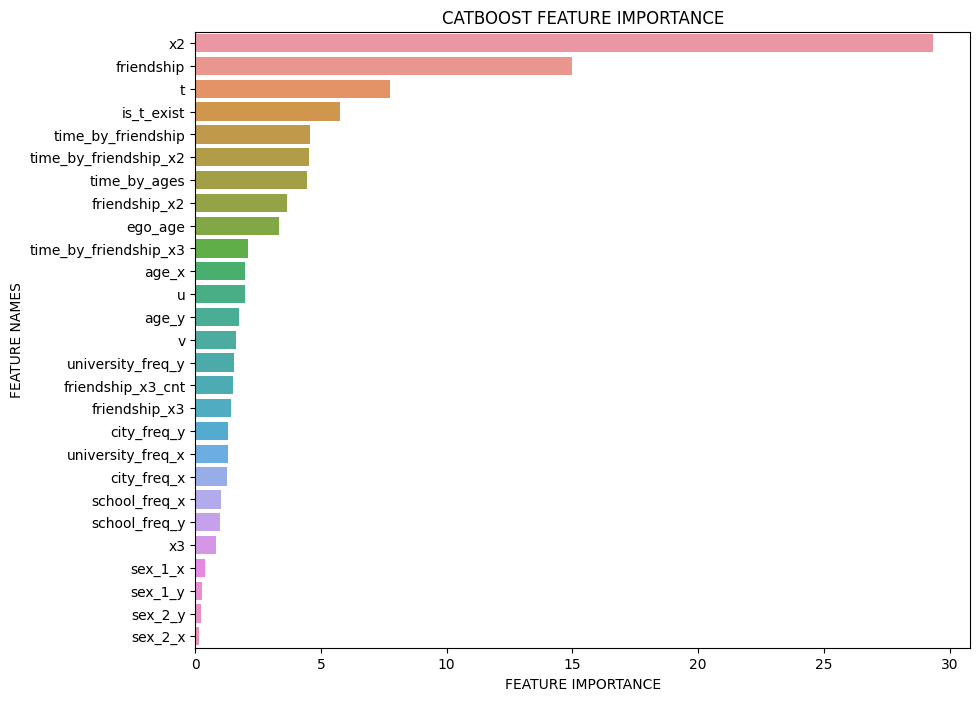

In [32]:
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(cat.get_feature_importance(),x_train.columns,'CATBOOST ')

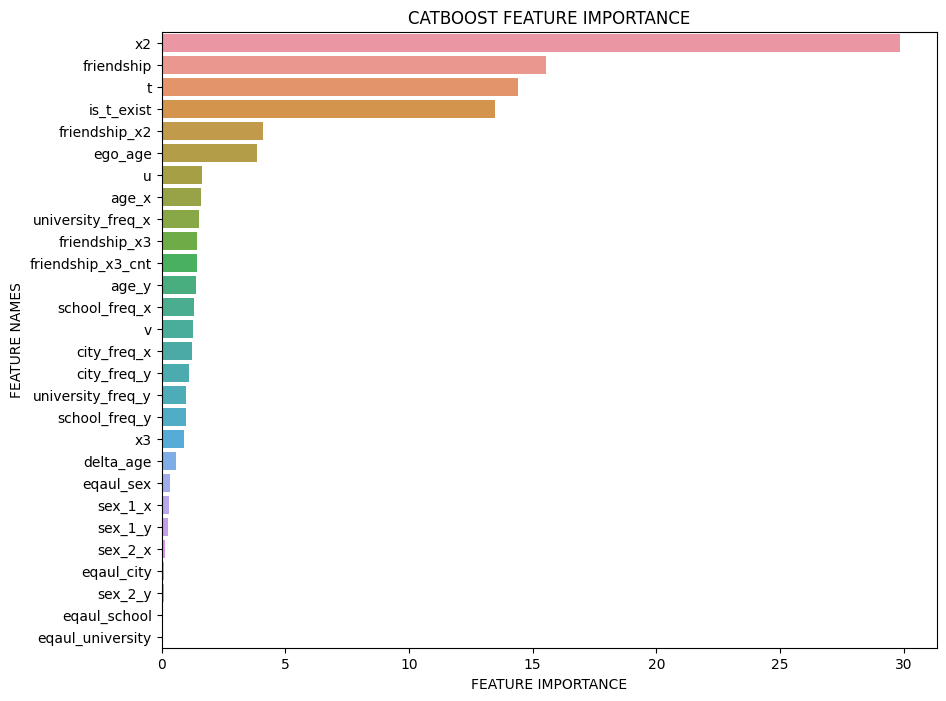

In [16]:
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(cat.get_feature_importance(),x_train.columns,'CATBOOST ')

### Feature Importance

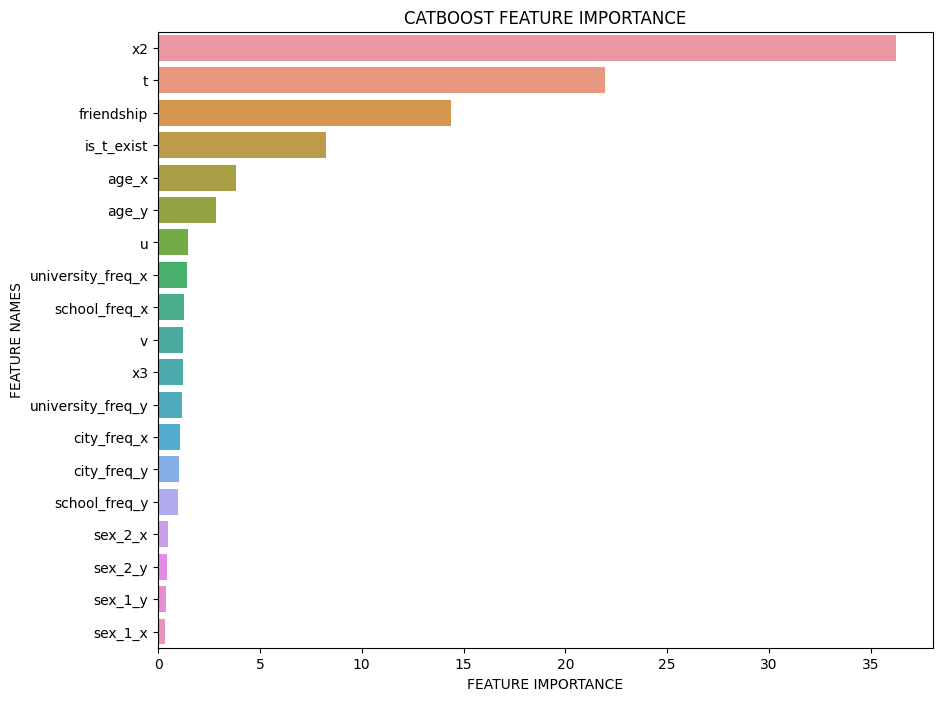

In [44]:
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(cat.get_feature_importance(),x_train.columns,'CATBOOST ')

In [26]:
# # Производим кроссвалидацию (минимальная)
params = {"iterations": 100,
          "loss_function": "RMSE",
          "random_strength":2, 
          "depth":7, 
          "learning_rate":0.2, 
          "l2_leaf_reg":3
          "verbose": False}
cv_dataset = Pool(data=x_train,
                  label=y_train)

scores = cv(cv_dataset,
            params, 
            fold_count=5, 
            plot="True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]


KeyboardInterrupt: 

In [48]:
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [46]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



In [47]:
model_xgb.fit(x_train, y_train)
# xgb_pred = np.expm1(model_xgb.predict(test))



[21:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [50]:
xgb_val_pred = model_xgb.predict(x_val)
print(rmsle(y_val, xgb_val_pred))

0.7569711489904081


In [93]:
# Формируем предсказания на тестовых данных
test_df["predict"] = cat.predict(y_test)
test_df

,ego_id,u,v,t,x1,x2,x3,is_t_exist,friendship,age_x,...,city_freq_x,university_freq_x,school_freq_x,age_y,sex_1_y,sex_2_y,city_freq_y,university_freq_y,school_freq_y,predict
1,42949673176,0,98,225.9,NaN,0.0,0.0,1,0.228191,35,...,13,154,101,30,0,1,98,154,16,0.154035
2,42949673176,97,98,221.2,NaN,0.0,0.0,1,0.569724,32,...,98,154,5,30,0,1,98,154,16,0.342764
5,42949673176,121,98,233.5,NaN,0.0,0.0,1,0.538926,25,...,9,1,16,30,0,1,98,154,16,0.327783
21,42949673176,35,298,299.6,NaN,0.0,0.0,1,0.316065,30,...,98,154,16,32,0,1,98,154,101,0.179833
22,42949673176,94,298,253.9,NaN,0.0,0.0,1,0.165649,28,...,98,154,4,32,0,1,98,154,101,0.153965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855901,566935683204,5,6,460.1,NaN,0.0,0.0,1,0.052645,16,...,70,1,118,36,0,1,42,8,1,0.066407
855913,566935683204,111,19,294.2,NaN,0.0,0.0,1,0.097542,31,...,1,144,118,36,0,1,70,1,1,0.040098
855914,566935683204,23,19,445.7,NaN,0.0,0.0,1,0.094703,35,...,2,144,2,36,0,1,70,1,1,0.042189
855919,566935683204,205,105,378.8,NaN,0.0,0.0,1,0.001638,37,...,44,144,34,37,0,1,44,6,34,0.010970


### Обновляем знания в submission.csv

In [94]:
# Скачиваем действующий сабмит
submission = pd.read_csv(PATH + submission_filename)
submission.shape

(810976, 4)

In [95]:
# Объединяем с предсказаниями из теста
result_submission = submission.merge(test_df[["ego_id", "u", "v", "predict"]], on=["ego_id", "u", "v"], how='left')
result_submission.shape

(810976, 5)

In [96]:
# Обновляем сабмит тмеми предсказаниями которые получены от модели
result_submission["x1"] = result_submission.apply(lambda x: x["x1"] if pd.isna(x["predict"]) else x["predict"], axis=1)
result_submission = result_submission[["ego_id", "u", "v", "x1"]]

In [97]:
# Сохраняем итоговый сабмит
result_submission.to_csv(PATH + "result_submission_3.csv", index=False)